Variables of filenames

In [47]:
#PLAINTREE FILES NAMES
directory='/Users/julnow/gsi/inz/jupyter/'
fileName = directory + 'PlainTree10K_ml_DCM_12gev.root'

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#from hipe4ml.model_handler import ModelHandler
#from hipe4ml.tree_handler import TreeHandler
from matplotlib.patches import ConnectionPatch
from matplotlib.backends.backend_pdf import PdfPages
#from hipe4ml import plot_utils

import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz

from sklearn.model_selection import cross_val_score
import scipy
from scipy.stats import uniform

from numpy import sqrt, log, argmax

import weakref 
import itertools

from CBM_ML import tree_importer,  KFPF_lambda_cuts, plot_tools
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer

import gc, os
from enum import Enum

In [49]:
#CUTS USED FOR DATA CLEANING
#momentums cuts
pzLowerCut = 0
pUpperCut = 12
ptUpperCut = 2
#time
tUpperCut = 40
#pid codes of particles
class Pid(Enum):
    ELECTRON = 11
    POSITRON = -11
    PROTON = 2212 
    NEG_MUON = -13
    POS_MUON = 13
    NEG_PION = -211
    POS_PION = 211 
    NEG_KAON = -321
    POS_KAON = 321 
    GHOST = -999
    @classmethod
    def is_known_particle(cls, value):
        return value in cls._value2member_map_ 
    
def clean_df(df, info = 0):
    # let's treat all the infinite, inf, values by nan and then we drop all the null entries
    with pd.option_context('mode.use_inf_as_na', True):
        df = df.dropna()
    #Experimental constraints
    #pz
    size_pz =  len(df['pz'])
    is_good_pz = (df['pz'] > pzLowerCut)
    percentage_pz = ( size_pz - len(df[is_good_pz]) ) / size_pz
    #p
    size_p =  len(df['p'])
    is_good_p = (df['p'] < pUpperCut)
    percentage_p = ( size_p - len(df[is_good_p]) ) / size_p
    #p
    size_pt =  len(df['pT'])
    is_good_pt = (df['pT'] < ptUpperCut)
    percentage_pt = ( size_pt - len(df[is_good_pt]) ) / size_pt
    #t
    size_t =  len(df['t'])
    is_good_t = (df['t'] < tUpperCut)
    percentage_t = ( size_t - len(df[is_good_t]) ) / size_t
    is_good_df = (is_good_pz) & (is_good_p) & (is_good_pt) & (is_good_t)
    if (info == 1):
        print('with the pz selection criteria we lose we loose ' + str(round(percentage_pz*100, 4)) + '% of entries')
        print('with the p selection criteria we lose we loose ' + str(round(percentage_p*100, 4)) + '% of entries')
        print('with the pT selection criteria we lose we loose ' + str(round(percentage_pt*100, 4)) + '% of entries')
        print('with the t selection criteria we lose we loose ' + str(round(percentage_t*100, 4)) + '% of entries')

    return df[is_good_df]

To import the root files with simulated data as PlainTrees into Panda's dataframes format we use the function from **CBM_ML_LAMBDA_LIBRARY** prepared by Shahid.

In [50]:
#Shahid's library for importing roottrees
# %%capture
!git clone https://github.com/shahidzk1/CBM_ML_Lambda_Library.git
%cd CBM_ML_Lambda_Library
!git pull origin main
!pip install -r requirements.txt
!python setup.py install
from CBM_ML import tree_importer, plot_tools, KFPF_lambda_cuts

fatal: destination path 'CBM_ML_Lambda_Library' already exists and is not an empty directory.
/Users/julnow/gsi/inz/jupyter/CBM_ML_Lambda_Library/CBM_ML_Lambda_Library
hint: Pulling without specifying how to reconcile divergent branches is
hint: discouraged. You can squelch this message by running one of the following
hint: commands sometime before your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured default per
hint: invocation.
From https://github.com/shahidzk1/CBM_ML_Lambda_Library
 * branch            main       -> FETCH_HEAD
Already up to date.
running install
running bdist_egg
running egg_info
writing CBM_ML.eg

In [51]:
# We import three root files into our jupyter notebook
particles = tree_importer.tree_importer(fileName,'plain_tree',7)
particles.columns = particles.columns.str.replace('Complex_', '')
# bckgr = bckgr[(bckgr['Candidates_generation'] < 1)
#                  & ((bckgr['Candidates_mass'] > lower5SigmaCutBckgr)
#                  & (bckgr['Candidates_mass'] < lower5SigmaCutSign) | (bckgr['Candidates_mass']>upper5SigmaCutSign) 
gc.collect()
#let's add velocity field
particles['v'] = particles['l']/particles['t']
particles = clean_df(particles)
particles.iloc[0:10,:]

,eta,l,mass,p,pT,phi,px,py,pz,rapidity,t,pid,q,v
0,1.772989,726.968933,0.938272,3.081436,1.017269,-2.501104,-0.815650,-0.607907,2.908679,1.488253,25.257862,2212.0,1.0,28.781887
1,2.434091,789.583557,0.938272,2.045768,0.355999,-1.127488,0.152699,-0.321587,2.014555,1.446963,26.548641,2212.0,1.0,29.741016
2,1.923849,794.463928,0.139570,0.925076,0.264560,-2.625532,-0.230107,-0.130549,0.886438,1.806840,26.454737,211.0,1.0,30.031065
3,2.448442,753.877502,0.938272,8.301641,1.424350,-0.910986,0.873079,-1.125392,8.178537,2.271433,25.385580,2212.0,1.0,29.697077
4,2.299000,752.853638,0.938272,1.316773,0.261665,-2.482023,-0.206782,-0.160342,1.290513,1.093517,25.362499,2212.0,1.0,29.683733
5,2.859857,763.913025,0.938272,3.449825,0.393898,-1.800607,-0.089727,-0.383542,3.427263,1.928807,27.897562,2212.0,1.0,27.382788
6,2.885593,763.653015,0.139570,1.869297,0.208047,-1.574484,-0.000767,-0.208045,1.857684,2.701191,25.378315,-211.0,1.0,30.090769
7,2.840546,747.993958,0.139570,2.500303,0.291011,-1.223433,0.099066,-0.273630,2.483310,2.737813,25.116238,211.0,1.0,29.781290
8,3.017349,793.801025,0.000511,6.246289,0.609811,-1.780552,-0.126976,-0.596445,6.216451,3.017349,26.594879,11.0,1.0,29.847891
9,3.101090,794.461365,0.938272,6.787242,0.609614,-1.850472,-0.168281,-0.585928,6.759809,2.498553,28.626184,2212.0,1.0,27.752960


In [52]:
#we'll set other particles to one pid code (ghost)
for particle in particles['pid'].unique():
    if not Pid.is_known_particle(particle):
         particles.replace(particle, Pid.GHOST.value, inplace=True)
#changing ids to (0. nmb] for xgboost training
i = 0
for particle in Pid:
    particles['pid'].replace(particle.value, i, inplace=True)
    i += 1
particles.iloc[0:10,:]

,eta,l,mass,p,pT,phi,px,py,pz,rapidity,t,pid,q,v
0,1.772989,726.968933,0.938272,3.081436,1.017269,-2.501104,-0.815650,-0.607907,2.908679,1.488253,25.257862,2.0,1.0,28.781887
1,2.434091,789.583557,0.938272,2.045768,0.355999,-1.127488,0.152699,-0.321587,2.014555,1.446963,26.548641,2.0,1.0,29.741016
2,1.923849,794.463928,0.139570,0.925076,0.264560,-2.625532,-0.230107,-0.130549,0.886438,1.806840,26.454737,6.0,1.0,30.031065
3,2.448442,753.877502,0.938272,8.301641,1.424350,-0.910986,0.873079,-1.125392,8.178537,2.271433,25.385580,2.0,1.0,29.697077
4,2.299000,752.853638,0.938272,1.316773,0.261665,-2.482023,-0.206782,-0.160342,1.290513,1.093517,25.362499,2.0,1.0,29.683733
5,2.859857,763.913025,0.938272,3.449825,0.393898,-1.800607,-0.089727,-0.383542,3.427263,1.928807,27.897562,2.0,1.0,27.382788
6,2.885593,763.653015,0.139570,1.869297,0.208047,-1.574484,-0.000767,-0.208045,1.857684,2.701191,25.378315,5.0,1.0,30.090769
7,2.840546,747.993958,0.139570,2.500303,0.291011,-1.223433,0.099066,-0.273630,2.483310,2.737813,25.116238,6.0,1.0,29.781290
8,3.017349,793.801025,0.000511,6.246289,0.609811,-1.780552,-0.126976,-0.596445,6.216451,3.017349,26.594879,0.0,1.0,29.847891
9,3.101090,794.461365,0.938272,6.787242,0.609614,-1.850472,-0.168281,-0.585928,6.759809,2.498553,28.626184,2.0,1.0,27.752960


In [53]:
# The following columns will be used to predict whether a reconstructed candidate is a lambda particle or not
params = [ 'p', 'pT', 'eta', 'v', 'q'] 
x = particles[params].copy()

# The MC information is saved in this y variable
y =pd.DataFrame(particles['pid'], dtype='int')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=324)
del particles, x, y

#DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed. 
dtrain = xgb.DMatrix(x_train, label = y_train)
dtest1=xgb.DMatrix(x_test, label = y_test)
# del x_test
gc.collect()

40

In [ ]:
def bo_tune_xgb(max_depth, gamma, alpha,learning_rate):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'alpha':alpha,
              'learning_rate':learning_rate,
              'subsample': 0.8,
              'eta': 0.3,
              'num_class':np.unique(dtrain.get_label()).shape[0],
              'objective':'multi:softmax', 
              'eval_metric': 'mlogloss','tree_method':'hist', 'nthread' : 7}
    cv_result = xgb.cv(params=params, dtrain=dtrain, num_boost_round=10, nfold=5)
    return cv_result['test-mlogloss-mean'].iloc[-1]
bounds_transformer = SequentialDomainReductionTransformer()
#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (4, 10),
                                             'gamma': (0, 1),
                                            'alpha': (2,20),
                                             'learning_rate':(0.01,1),
                                            },
                              bounds_transformer=bounds_transformer)

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=5, acq='ei')

|   iter    |  target   |   alpha   |   gamma   | learni... | max_depth |
-------------------------------------------------------------------------
|  1        |  1.437    |  3.244    |  0.9952   |  0.7125   |  5.163    |
|  2        |  1.436    |  18.12    |  0.1888   |  0.7669   |  4.746    |
|  3        |  1.439    |  2.333    |  0.4766   |  0.5844   |  6.036    |


In [ ]:
max_param = xgb_bo.max['params']
param= {'alpha': max_param['alpha'], 'gamma': max_param['gamma'], 'learning_rate': max_param['learning_rate'],
        'max_depth': int(round(max_param['max_depth'],0)), 'num_class':np.unique(dtrain.get_label()).shape[0],
         'objective':'multi:softmax','eval_metric': 'mlogloss', 'tree_method':'hist','nthread' : 7}

#Fit/train on training data
bst = xgb.XGBClassifier(**param).fit(x_train, y_train)

#predicitions on training set
bst_train= pd.DataFrame(data=bst.predict_proba(x_train))
y_train=y_train.set_index(np.arange(0,bst_train.shape[0]))
bst_train['xgb_preds']=bst_train.iloc[:,0:(len(bst_train.columns)-1)].idxmax(axis = 1)
bst_train['pid']=y_train['pid']

bst_test = pd.DataFrame(data=bst.predict_proba(x_test))
bst_test['xgb_preds']=bst_test.iloc[:,0:(len(bst_test.columns)-1)].idxmax(axis = 1)
y_test=y_test.set_index(np.arange(0,bst_test.shape[0]))
bst_test['pid']=y_test['pid']

In [ ]:
bst_test

## Another set
We also select the selected variables from the 10k events data set

In [17]:
#TO CHANGE
fileNameTest = fileName

# We import three root files into our jupyter notebook
particlesTest = tree_importer.tree_importer(fileNameTest,'plain_tree',7)
particlesTest.columns = particlesTest.columns.str.replace('Complex_', '')
# bckgr = bckgr[(bckgr['Candidates_generation'] < 1)
#                  & ((bckgr['Candidates_mass'] > lower5SigmaCutBckgr)
#                  & (bckgr['Candidates_mass'] < lower5SigmaCutSign) | (bckgr['Candidates_mass']>upper5SigmaCutSign) 
gc.collect()
#let's add velocity field
particlesTest['v'] = particlesTest['l']/particlesTest['t']
particlesTest = clean_df(particlesTest)
#we'll set other particles to one pid code (ghost)
for particle in particlesTest['pid'].unique():
    if not Pid.is_known_particle(particle):
         particlesTest.replace(particle, Pid.GHOST.value, inplace=True)
#changing ids to (0. nmb] for xgboost training
i = 0
for particle in Pid:
    particlesTest['pid'].replace(particle.value, i, inplace=True)
    i += 1
particlesTest.iloc[0:10,:]

,eta,l,mass,p,pT,phi,px,py,pz,rapidity,t,pid,q,v
0,1.772989,726.968933,0.938272,3.081436,1.017269,-2.501104,-0.815650,-0.607907,2.908679,1.488253,25.257862,2.0,1.0,28.781887
1,2.434091,789.583557,0.938272,2.045768,0.355999,-1.127488,0.152699,-0.321587,2.014555,1.446963,26.548641,2.0,1.0,29.741016
2,1.923849,794.463928,0.139570,0.925076,0.264560,-2.625532,-0.230107,-0.130549,0.886438,1.806840,26.454737,6.0,1.0,30.031065
3,2.448442,753.877502,0.938272,8.301641,1.424350,-0.910986,0.873079,-1.125392,8.178537,2.271433,25.385580,2.0,1.0,29.697077
4,2.299000,752.853638,0.938272,1.316773,0.261665,-2.482023,-0.206782,-0.160342,1.290513,1.093517,25.362499,2.0,1.0,29.683733
5,2.859857,763.913025,0.938272,3.449825,0.393898,-1.800607,-0.089727,-0.383542,3.427263,1.928807,27.897562,2.0,1.0,27.382788
6,2.885593,763.653015,0.139570,1.869297,0.208047,-1.574484,-0.000767,-0.208045,1.857684,2.701191,25.378315,5.0,1.0,30.090769
7,2.840546,747.993958,0.139570,2.500303,0.291011,-1.223433,0.099066,-0.273630,2.483310,2.737813,25.116238,6.0,1.0,29.781290
8,3.017349,793.801025,0.000511,6.246289,0.609811,-1.780552,-0.126976,-0.596445,6.216451,3.017349,26.594879,0.0,1.0,29.847891
9,3.101090,794.461365,0.938272,6.787242,0.609614,-1.850472,-0.168281,-0.585928,6.759809,2.498553,28.626184,2.0,1.0,27.752960


In [18]:
x_whole = particlesTest[params].copy()
y_whole = pd.DataFrame(particlesTest['pid'], dtype='int')
dtest = xgb.DMatrix(x_whole, label = y_whole)
del x_whole
gc.collect()

9

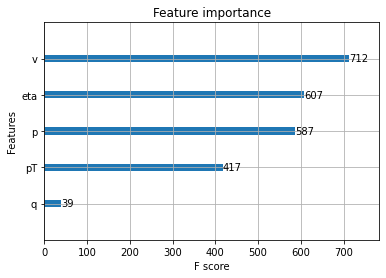

In [19]:
#The following graph will show us that which features are important for the model
ax = xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [5, 3]
plt.show()
ax.figure.tight_layout() 
# ax.figure.savefig(directory+'img/xgb_12agev/chi2geo/feature_importance.pdf')
# ax.figure.savefig(directory+'img/xgb_12agev/chi2geo/feature_importance.png')

## AUC and ROC

The function roc_curve computes the receiver operating characteristic curve, or ROC curve. Quoting Wikipedia :

“A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.”

This function requires the true binary value and the target scores, which can either be probability estimates of the positive class, confidence values, or binary decisions.

Similarly, the function roc_auc_score computes Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

To find the best threshold which results more signal to background ratio for lambda candidates we use the parameter S0 called the approximate median significance by the higgs boson  ML challenge (http://higgsml.lal.in2p3.fr/documentation,9.)

In [16]:
def preds_prob(df,preds,true,df1,preds1, true1):
    fig, ax = plt.subplots(figsize=(12, 8))
    bins1=100
    TP = df[(df[true]==1)]
    TN = df[(df[true]==0)]
    
    plt.hist(TN[preds], bins=bins1,facecolor='blue',alpha = 0.3, label='background in train')
    plt.hist(TP[preds], bins=bins1,facecolor='red',alpha = 0.3, label='signal in train')
    
    
    TP1 = df1[(df1[true1]==1)]
    TN1 = df1[(df1[true1]==0)]
    
    hist1, bins1 = np.histogram(TN1[preds1], bins=bins1)
    err1 = np.sqrt(hist1)
    center1 = (bins1[:-1] + bins1[1:]) / 2
    plt.errorbar(center1, hist1, yerr=err1, fmt='o',
                 c='blue', label='background in test')
    
    hist, bins = np.histogram(TP1[preds1], bins=bins1)
    err = np.sqrt(hist)
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o',
                 c='red', label='signal in test')
    
   # ax.annotate('cut on probability', xy=(0, 90), xycoords='data',xytext=(0.13,0.5), textcoords='axes fraction',
    # fontsize=15,arrowprops=dict(facecolor='black', shrink=0.05),horizontalalignment='right', verticalalignment='top')
    

    
    if df[true].unique().shape[0]>2:
        TP2= df[df[true]>1]
        plt.hist(TP2[preds], bins=bins1,facecolor='green',alpha = 0.3, label='secondaries in train')
        TP2= df1[df1[true1]>1]
        hist2, bins2 = np.histogram(TP2[preds1], bins=bins1)
        center2 = (bins2[:-1] + bins2[1:]) / 2
        err2 = np.sqrt(hist2)
        plt.errorbar(center2, hist2,yerr=err2, fmt='o',c='green',label='secondaries in test')

    
    ax.set_yscale('log')
    ax.set_xlabel('Probability',fontsize=18)
    plt.ylabel('Counts', fontsize=18)
    ax.set_xticks(np.arange(0,1.1,0.1))
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    plt.legend(fontsize=18)
    fig.show()
    fig.tight_layout()
    return fig, ax
preds_prob()

In [20]:
def AMS(y_true, y_predict, y_true1, y_predict1):
    roc_auc=roc_auc_score(y_true, y_predict)
    fpr, tpr, thresholds = roc_curve(y_true, y_predict,drop_intermediate=False ,pos_label=1)
    S0 = sqrt(2 * ((tpr + fpr) * log((1 + tpr/fpr)) - tpr))
    S0 = S0[~np.isnan(S0)]
    xi = argmax(S0)
    S0_best_threshold = (thresholds[xi])

    roc_auc1=roc_auc_score(y_true1, y_predict1)
    fpr1, tpr1, thresholds1 = roc_curve(y_true1, y_predict1,drop_intermediate=False ,pos_label=1)
    S01 = sqrt(2 * ((tpr1 + fpr1) * log((1 + tpr1/fpr1)) - tpr1))
    S01 = S01[~np.isnan(S01)]
    xi1 = argmax(S01)
    S0_best_threshold1 = (thresholds[xi1])

    #plotting
    fig, axs = plt.subplots(figsize=(15, 10), dpi = 300)
    plt.plot(fpr, tpr, linestyle=':',color='darkorange',label='ROC curve train (area = %0.4f)' % roc_auc)
    plt.plot(fpr1, tpr1, color='green',label='ROC curve test (area = %0.4f)' % roc_auc1)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.scatter(fpr[xi], tpr[xi], marker='o', color='black', label= 'Best Threshold train set = '+"%.4f" % S0_best_threshold +'\n AMS = '+ "%.2f" % S0[xi])
    plt.scatter(fpr1[xi1], tpr1[xi1], marker='o', color='blue', label= 'Best Threshold test set = '+"%.4f" % S0_best_threshold1 +'\n AMS = '+ "%.2f" % S01[xi1])
    plt.xlabel('False Positive Rate', fontsize = 24)
    plt.ylabel('True Positive Rate', fontsize = 24)
    plt.legend(loc="lower right", fontsize = 24)
    plt.title('Receiver operating characteristic', fontsize = 24)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0, 1.02])
    
    fig.tight_layout()
    plt.show()
    fig.savefig(directory+'img/xgb_12agev/chi2geo/ams.pdf')
    fig.savefig(directory+'img/xgb_12agev/chi2geo/ams.png')

    return S0_best_threshold, S0_best_threshold1

In [21]:
train_best, test_best = AMS(y_train, bst1, y_test, bst_test['xgb_preds'])

KeyError: 'xgb_preds'

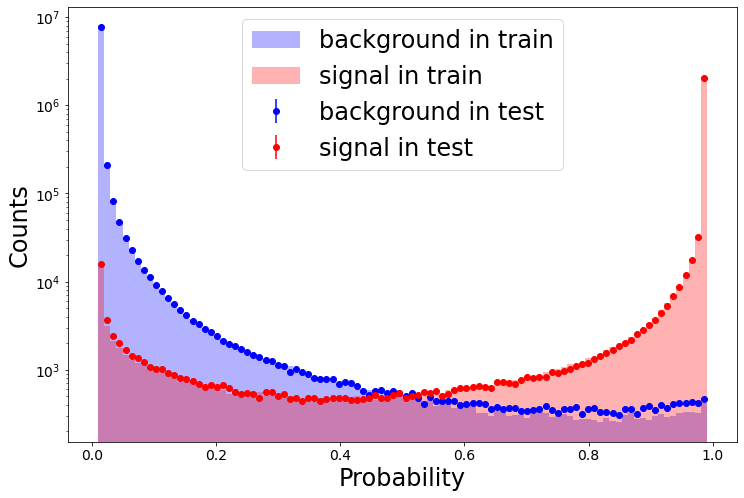

In [29]:
def preds_prob(df,preds,true,df1,preds1, true1):
    fig, ax = plt.subplots(figsize=(12, 8))
    bins1=100
    TP = df[(df[true]==1)]
    TN = df[(df[true]==0)]
    
    plt.hist(TN[preds], bins=bins1,facecolor='blue',alpha = 0.3, label='background in train')
    plt.hist(TP[preds], bins=bins1,facecolor='red',alpha = 0.3, label='signal in train')
    
    
    TP = df1[(df1[true1]==1)]
    TN = df1[(df1[true1]==0)]
    
    hist1, bins1 = np.histogram(TN[preds1], bins=bins1)
    err1 = np.sqrt(hist1)
    center1 = (bins1[:-1] + bins1[1:]) / 2
    plt.errorbar(center1, hist1, yerr=err1, fmt='o',
                 c='blue', label='background in test')
    
    hist, bins = np.histogram(TP[preds1], bins=bins1)
    err = np.sqrt(hist)
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o',
                 c='red', label='signal in test')
    

    
    if df[true].unique().shape[0]>2:
        TP2= df[df[true]>1]
        plt.hist(TP2[preds], bins=bins1,facecolor='green',alpha = 0.3, label='secondaries in train')
        TP2= df1[df1[true1]>1]
        hist2, bins2 = np.histogram(TP2[preds1], bins=bins1)
        center2 = (bins2[:-1] + bins2[1:]) / 2
        err2 = np.sqrt(hist2)
        plt.errorbar(center, hist2,yerr=err2, fmt='o',c='green',label='secondaries in test')

    
    ax.set_yscale('log')
    ax.set_xlabel('Probability',fontsize=24)
    plt.ylabel('Counts', fontsize=24)
    #ax.set_xticks(np.arange(0,1.1,0.1))
    plt.legend(fontsize=24)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.show()
    fig.tight_layout()
    fig.savefig(directory+'img/xgb_12agev/chi2geo/probability.pdf')
preds_prob(bst_train,'xgb_preds', 'issignal',bst_test,'xgb_preds','issignal')

When the AUC, best threshold and approximate median significance for train and test are nearly the same, we save that model and use it. This means that our model is general enough. In my opinion, if the test S0 is above 3.0 then it is a good enough model.

## Applying the model on the 10k events data-set

In [27]:
df_clean['xgb_preds'] = bst.predict(dtest)

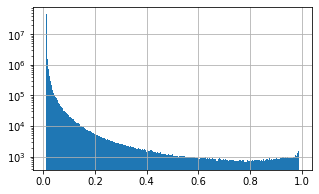

In [28]:
df_clean['xgb_preds'].hist(bins=300)
plt.yscale('log')

## Confusion Matrix

A **Confusion Matrix** $C$ is such that $C_{ij}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$. Thus in binary classification, the count of true positives is $C_{00}$, false negatives $C_{01}$,false positives is $C_{10}$, and true neagtives is $C_{11}$.

If $ y^{'}_{i} $ is the predicted value of the $ i$-th sample and $y_{i}$ is the corresponding true value, then the fraction of correct predictions over $ n_{samples}$ is defined as 
$$
True \: positives (y,y^{'}) =  \sum_{i=1}^{n_{samples} } 1 (y^{'}_{i} = y_{i}=1)
$$ 

The following function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted label',fontsize = 15)

In [30]:
#calculate efficency and false tu tru signal ratio
def confustion_stats(df, cm):
    all_signals = len(df.loc[df['issignal'] == 1])
    true_signal = cm[0][0]
    false_signal = cm[1][0]        
    reconstructed_signals = true_signal + false_signal
    false_to_true_signals = false_signal / true_signal
    efficiency = reconstructed_signals / all_signals * 100 #efficency in % for all
    efficiency_true = true_signal / all_signals * 100 #efficency in % for all
    print("Efficiency: " + str(round(efficiency, 2)) + "%")
    print("Efficiency of true signal candidates reconstruction: " + str(round(efficiency_true, 2)) + "%")
    print("False tu true reconstructed signal ratio: " + str(round(false_to_true_signals, 2)))

In [31]:
test_best=0.988

Confusion matrix, without normalization
[[   26429     3423]
 [    1078 55478844]]


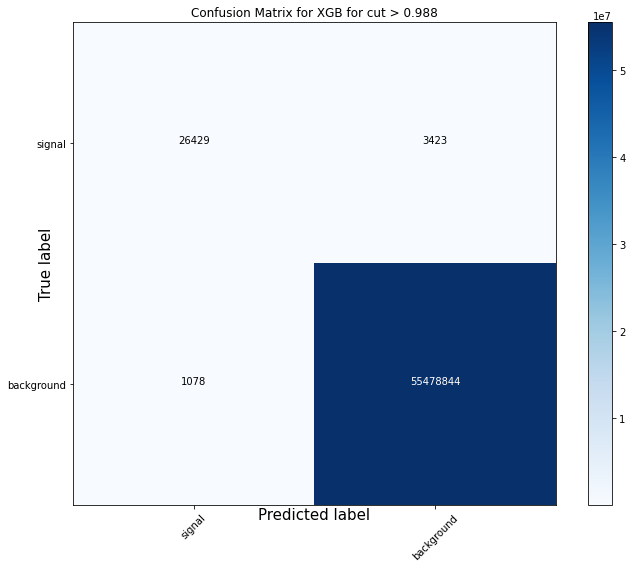

In [32]:
#lets take the best threshold and look at the confusion matrix
cut1 = test_best
df_clean['xgb_preds1'] = ((df_clean['xgb_preds']>cut1)*1) #1==signal decided by probability
cnf_matrix = confusion_matrix(y_whole, df_clean['xgb_preds1'], labels=[1,0])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
plot_confusion_matrix(cnf_matrix, classes=['signal','background'], title='Confusion Matrix for XGB for cut > '+str(cut1))
fig.savefig(directory+'img/xgb_12agev/chi2geo/confusion_matrix_extreme_gradient_boosting_whole_data.pdf')
fig.savefig(directory+'img/xgb_12agev/chi2geo/confusion_matrix_extreme_gradient_boosting_whole_data.png')

In [35]:
confustion_stats(df_clean, cnf_matrix)

Efficiency: 92.39%
Efficiency of true signal candidates reconstruction: 88.64%
False tu true reconstructed signal ratio: 0.04


with old params from gradient boosting, but new xgb
Efficiency: 88.1%
Efficiency of true signal candidates reconstruction: 85.3%
False tu true reconstructed signal ratio: 0.03

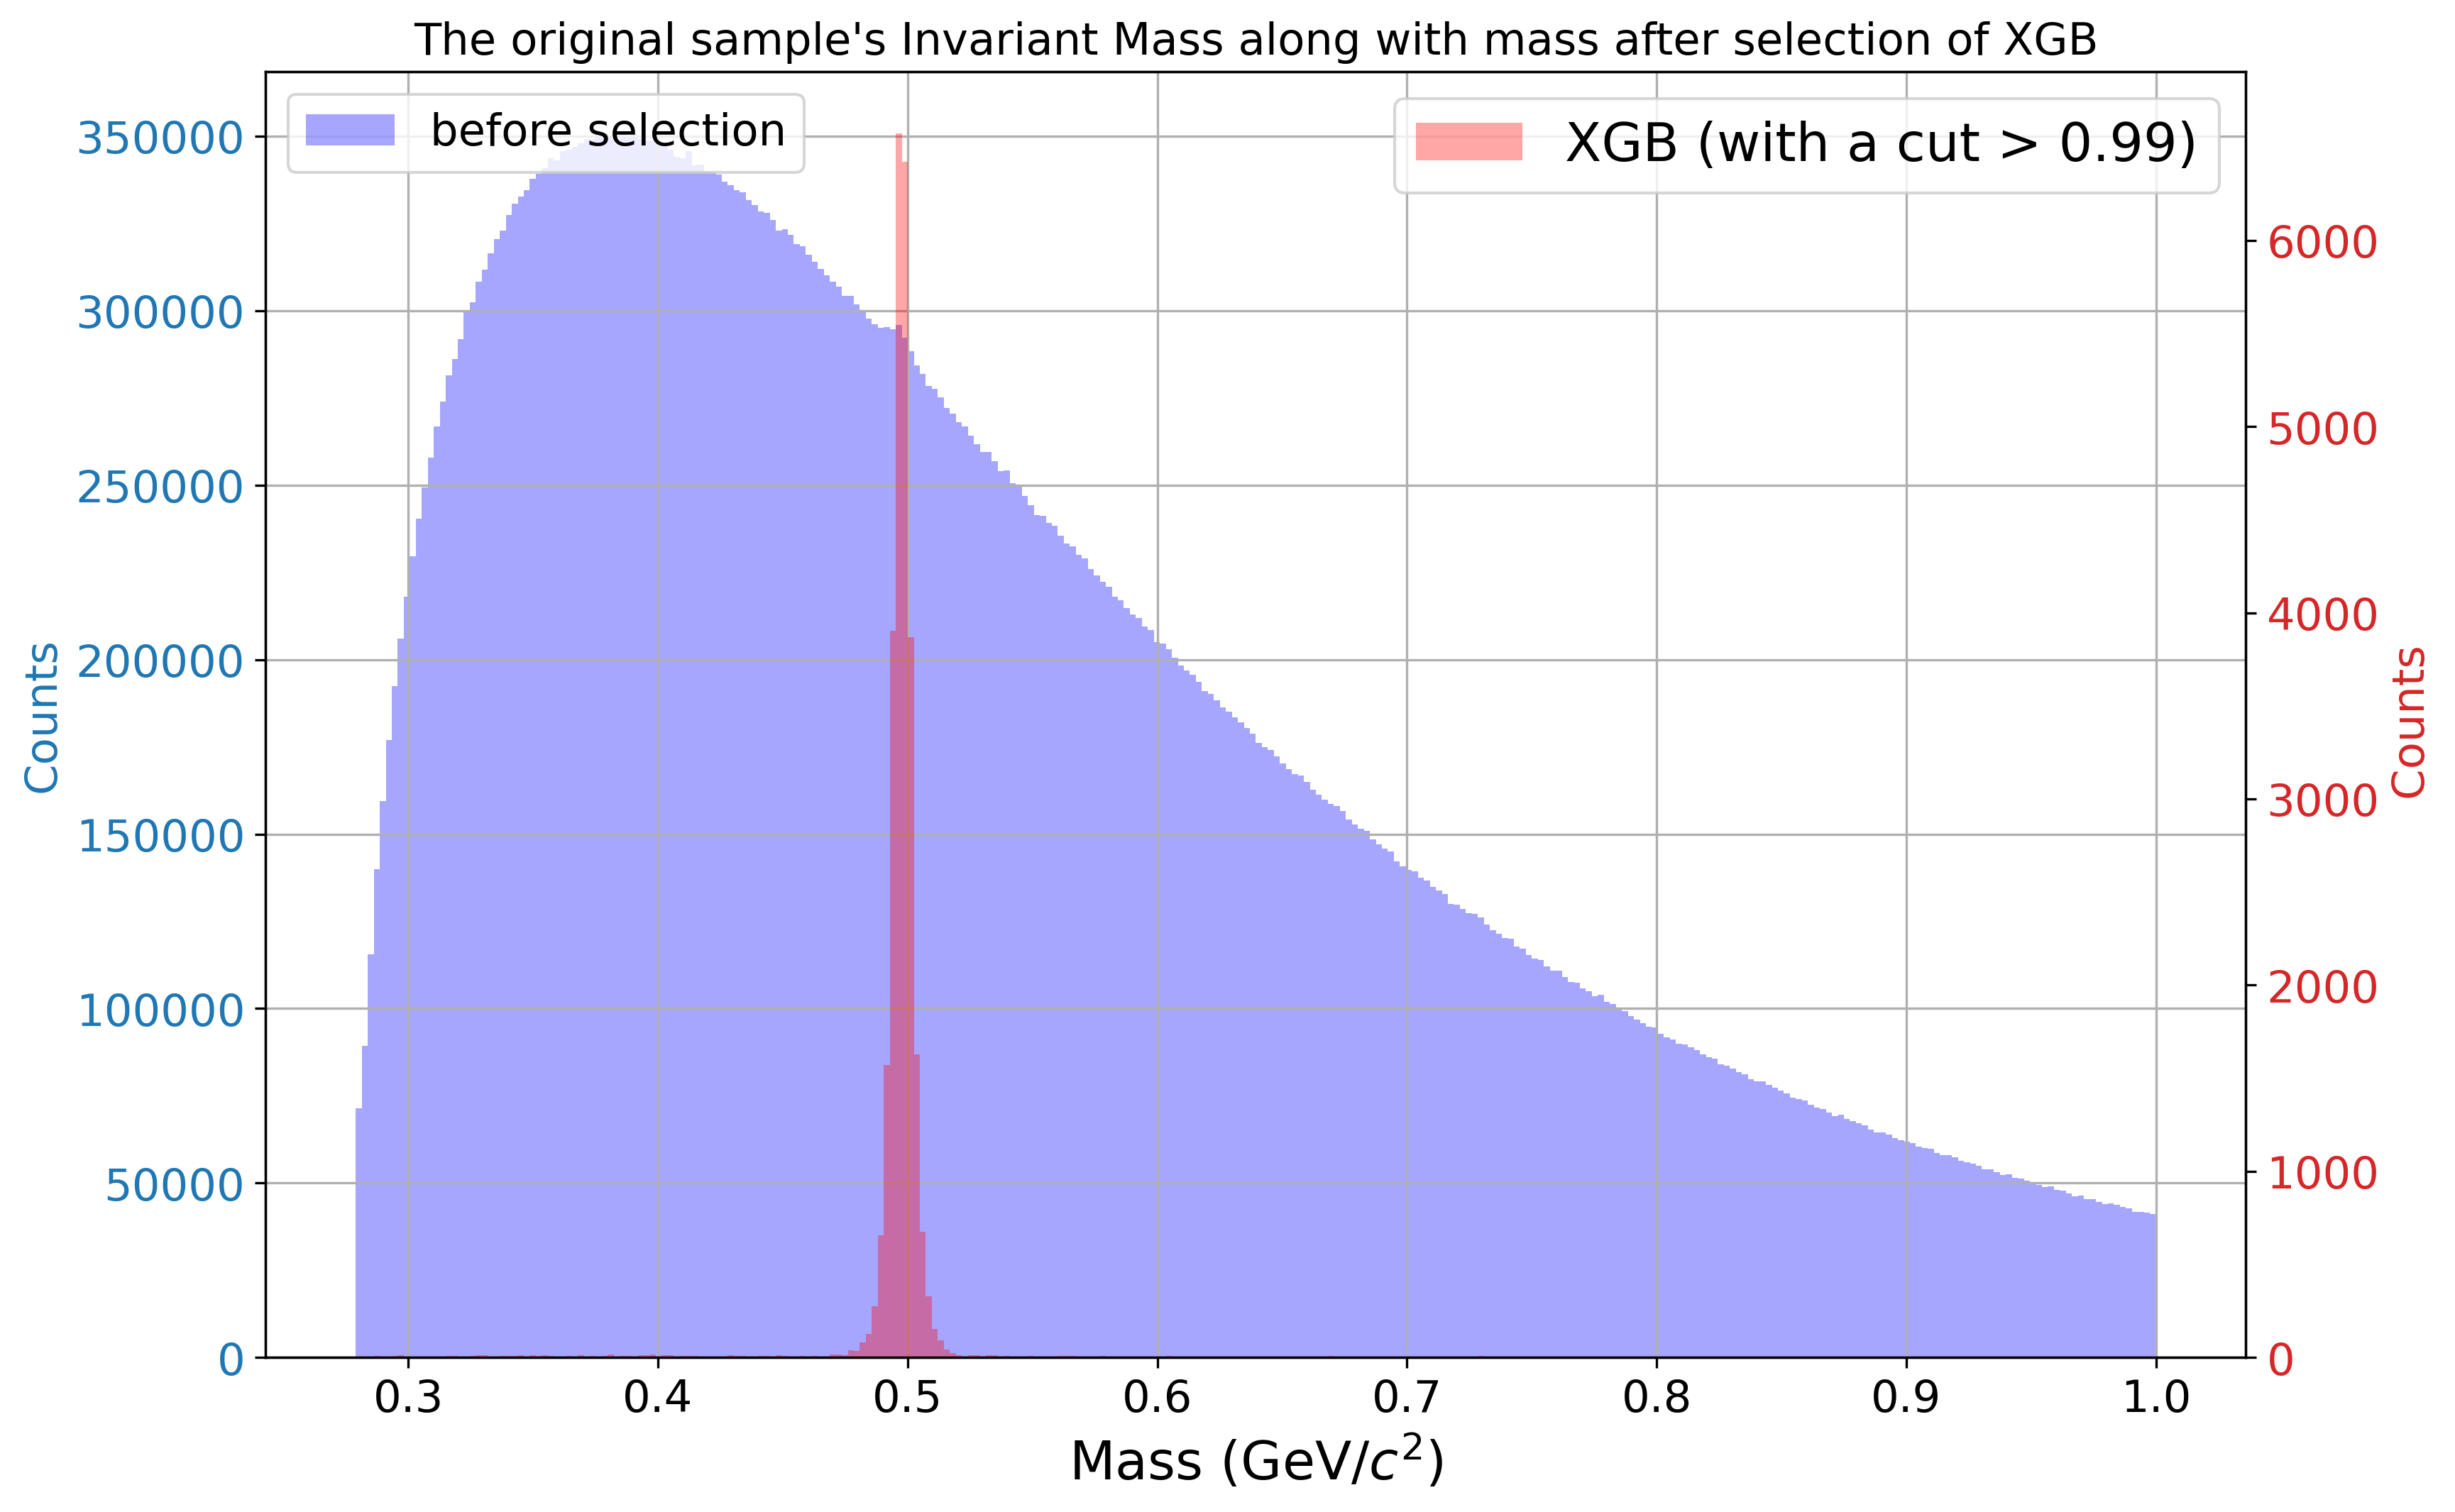

In [33]:
def cut_visualization(df, variable, cut, range1=(lowerMassCut, upperMassCut), bins1= 300 ):
    mask1 = df[variable]>cut
    df3=df[mask1]
    
    fig, ax2 = plt.subplots(figsize=(12, 8), dpi = 300)
    color = 'tab:blue'
    ax2.hist(df['mass'],bins = bins1, range=range1, facecolor='blue' ,alpha = 0.35, label='before selection')
    ax2.set_ylabel('Counts', fontsize = 15, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend( fontsize = 15, loc='upper left')
    ax2.tick_params(axis='both', which='major', labelsize=15)
    ax2.grid()
    ax2.set_xlabel("Mass (GeV/${c^2}$)", fontsize = 18)
    
    color = 'tab:red'
    ax1 = ax2.twinx()
    ax1.hist(df3['mass'], bins = bins1, range=range1, facecolor='red',alpha = 0.35, label="XGB (with a cut > %.2f"%cut+')')
    ax1.set_xlabel('Mass in GeV', fontsize = 15)
    ax1.set_ylabel('Counts ', fontsize = 15, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='both', which='major', labelsize=15)
    ax1.legend( fontsize = 18,loc='upper right' )

    plt.title("The original sample's Invariant Mass along with mass after selection of XGB", fontsize = 15)
    #plt.text(0.02, 0.1, r'cut > %.4f'%cut, fontsize=15)
    plt.show()
    fig.tight_layout()
    fig.savefig(directory+'img/xgb_12agev/chi2geo/cut_visualization.png')
    
cut_visualization(df_clean, 'xgb_preds', 0.988)

/var/folders/_8/1pnnpyz111s3q4bf02xypbgc0000gn/T/ipykernel_2532/2353810236.py:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ns, bins, patches=axs[0].hist((df[(df[predictions_column]>cut_value) & (df[signal_column]==1)]['mass']),bins = bin1,histtype='step', range=range1,Fill=False, color='red', facecolor='red', linewidth=2)
/var/folders/_8/1pnnpyz111s3q4bf02xypbgc0000gn/T/ipykernel_2532/2353810236.py:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ns1, bins1, patches1=axs[0].hist((df[df[signal_column]==1]['mass']),bins = bin1,histtype='step', Fill=False, range=range1,facecolor='blue',linewidth=2)
/var/folders/_8/1pnnpyz111s3q4bf02xypbgc0000gn/T/ipykernel_2532/2353810236.py:21: RuntimeWarning: divide by zero encountered in true_divide
  err_dif = (ns / ns1) * (np.sqrt( ((err/ns)**2) + ((err1/ns1)**2)
/var/

(<Figure size 720x720 with 2 Axes>,
 array([<AxesSubplot:ylabel='log(counts)'>,
        <AxesSubplot:xlabel='Mass in $\\dfrac{GeV}{c^2}$', ylabel='XGB / MC'>],
       dtype=object))

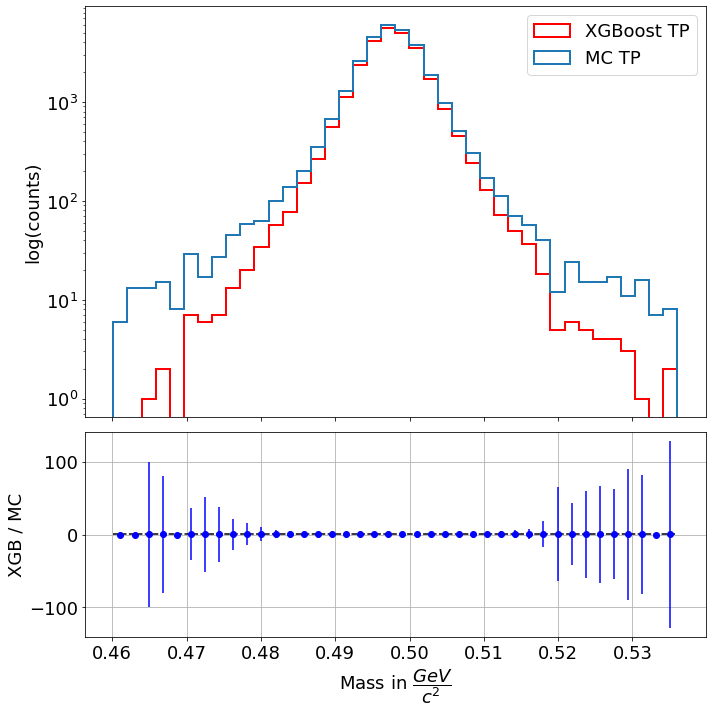

In [46]:
def efficiency_plot_mass(df,signal_column, predictions_column, cut_value, range_min, range_max, bin1):
    from matplotlib import gridspec
    x_min, x_max = range_min , range_max
    range1= (x_min, x_max)

    fig, axs = plt.subplots(2, 1,figsize=(10,10), sharex=True, constrained_layout=True, gridspec_kw={'width_ratios': [10],
                               'height_ratios': [8,4]})
    
    ns, bins, patches=axs[0].hist((df[(df[predictions_column]>cut_value) & (df[signal_column]==1)]['mass']),bins = bin1,histtype='step', range=range1,Fill=False, color='red', facecolor='red', linewidth=2)
    ns1, bins1, patches1=axs[0].hist((df[df[signal_column]==1]['mass']),bins = bin1,histtype='step', Fill=False, range=range1,facecolor='blue',linewidth=2)

    #plt.xlabel("Mass in GeV", fontsize = 15)
    axs[0].set_ylabel("log(counts)", fontsize = 18)
    axs[0].legend(('XGBoost TP','MC TP'), fontsize = 18, loc='upper right')
    axs[0].tick_params(axis='both', which='major', labelsize=18)
    axs[0].set_yscale('log')

    err = np.std(ns)
    err1 = np.std(ns1)
    corr_ns_ns1 = np.corrcoef(ns,ns1)[[0],[1]][0]
    err_dif = (ns / ns1) * (np.sqrt( ((err/ns)**2) + ((err1/ns1)**2)
                                      -2* ((corr_ns_ns1*err*err1)/(ns*ns1))))


    axs[1].hlines(y=1, xmin=x_min, xmax=x_max, colors='black', linestyles='dashed', label='')
    center = (bins[:-1] + bins[1:]) / 2
    axs[1].errorbar(center, ns / ns1, yerr=err_dif, fmt='o',
                     c='Blue', label='Background in predictions')


    plt.xlabel("Mass in $\dfrac{GeV}{c^2}$", fontsize = 18)
    axs[1].set_ylabel("XGB / MC", fontsize = 18)
    axs[1].grid()
    axs[1].tick_params(axis='both', which='major', labelsize=18)
    fig.show()
    fig.tight_layout()
    fig.savefig(directory+'img/xgb_12agev/chi2geo/efficiency_plot_mass.png')
    return fig, axs
efficiency_plot_mass(df_clean,'issignal', 'xgb_preds', 0.988, 0.46015, 0.53605, 40)

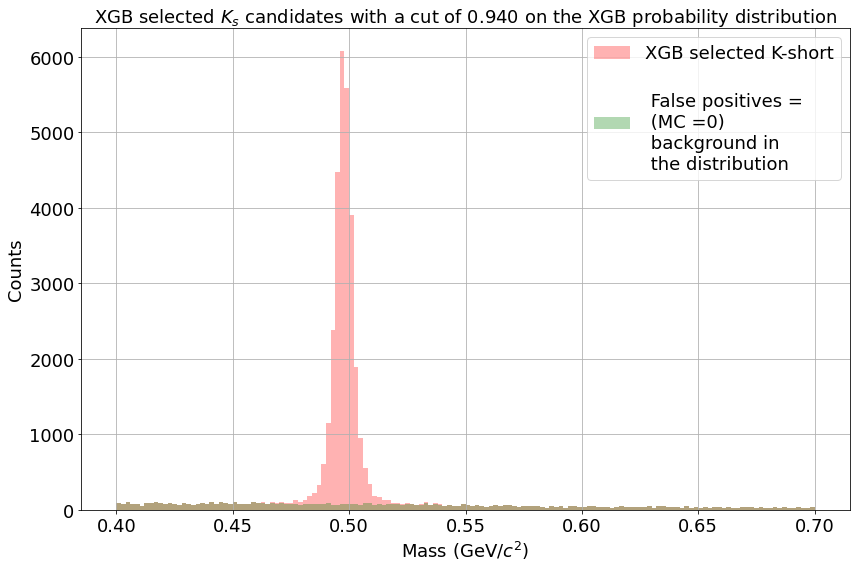

In [50]:
cut3 = 0.94
mask1 = df_clean['xgb_preds']>cut3
df3_base=df_clean[mask1]
fig, axs = plt.subplots(figsize=(12, 8))

range1= (.4, .7)
bins1 = 150

df3_base['mass'].plot.hist(bins = bins1, range=range1, facecolor='red',alpha = 0.3,grid=True,sharey=True, label='XGB selected K-short')
df3_base[df3_base['issignal']==0]['mass'].plot.hist(bins = bins1, range=range1,facecolor='green',alpha = 0.3,grid=True,sharey=True, label ='\n False positives = \n (MC =0)\n background in \n the distribution')

plt.legend( fontsize = 18, loc='upper right')
plt.title("XGB selected $K_{s}$ candidates with a cut of %.3f "%cut3 +"on the XGB probability distribution", fontsize = 18)
axs.set_xlabel("Mass (GeV/${c^2}$)", fontsize = 18)
plt.ylabel("Counts", fontsize = 18)
axs.tick_params(labelsize=18)
fig.tight_layout()
fig.savefig(directory+'img/xgb_12agev/chi2geo/true_and_false_signal.png')

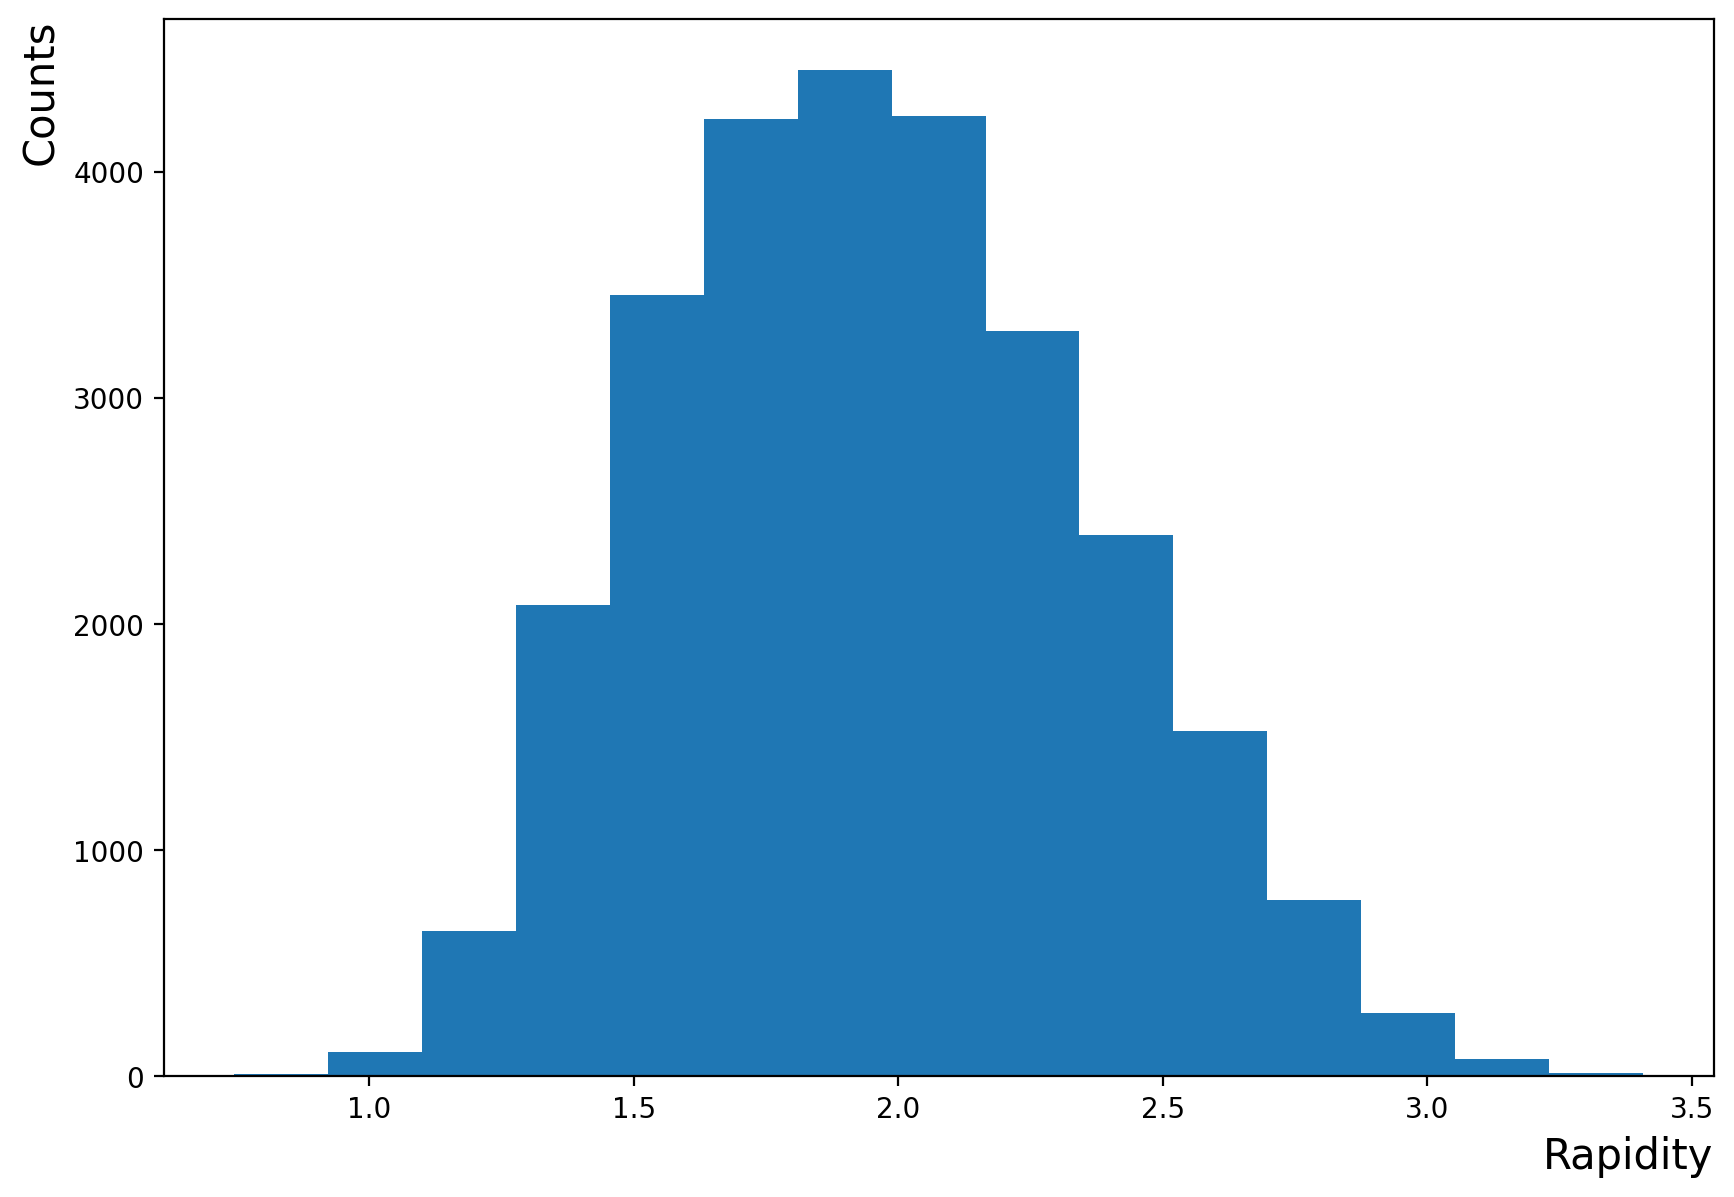

In [38]:
fig, ax = plt.subplots(figsize=(10, 7), dpi = 200)
ax.hist(df_clean[(df_clean['xgb_preds'] >test_best)]['rapidity'], bins=15)
ax.set_ylabel('Counts', fontsize = 15, loc='top')
ax.set_xlabel('Rapidity', fontsize = 15, loc='right')
fig.savefig(directory+'img/xgb_12agev/chi2geo/rapidity.png')

In [39]:
df_clean[(df_clean['xgb_preds'] >test_best)]['pT'].mean()

0.55779725

In [40]:
df_clean_sel = df_clean[(df_clean['xgb_preds1'] == 1)]

In [44]:
mid_rapidity = df_clean_sel[(df_clean_sel['rapidity']>1.8) & (df_clean_sel['rapidity']<2)]
mean_pt_mid_rapidity = mid_rapidity[(mid_rapidity['pT']>0.5) & (mid_rapidity['pT']<0.6)]
forward_rapidity = df_clean_sel[(df_clean_sel['rapidity']>2) & (df_clean_sel['rapidity']<2.2)]
mean_pt_forward_rapidity = forward_rapidity[(forward_rapidity['pT']>0.5) & (forward_rapidity['pT']<0.6)]

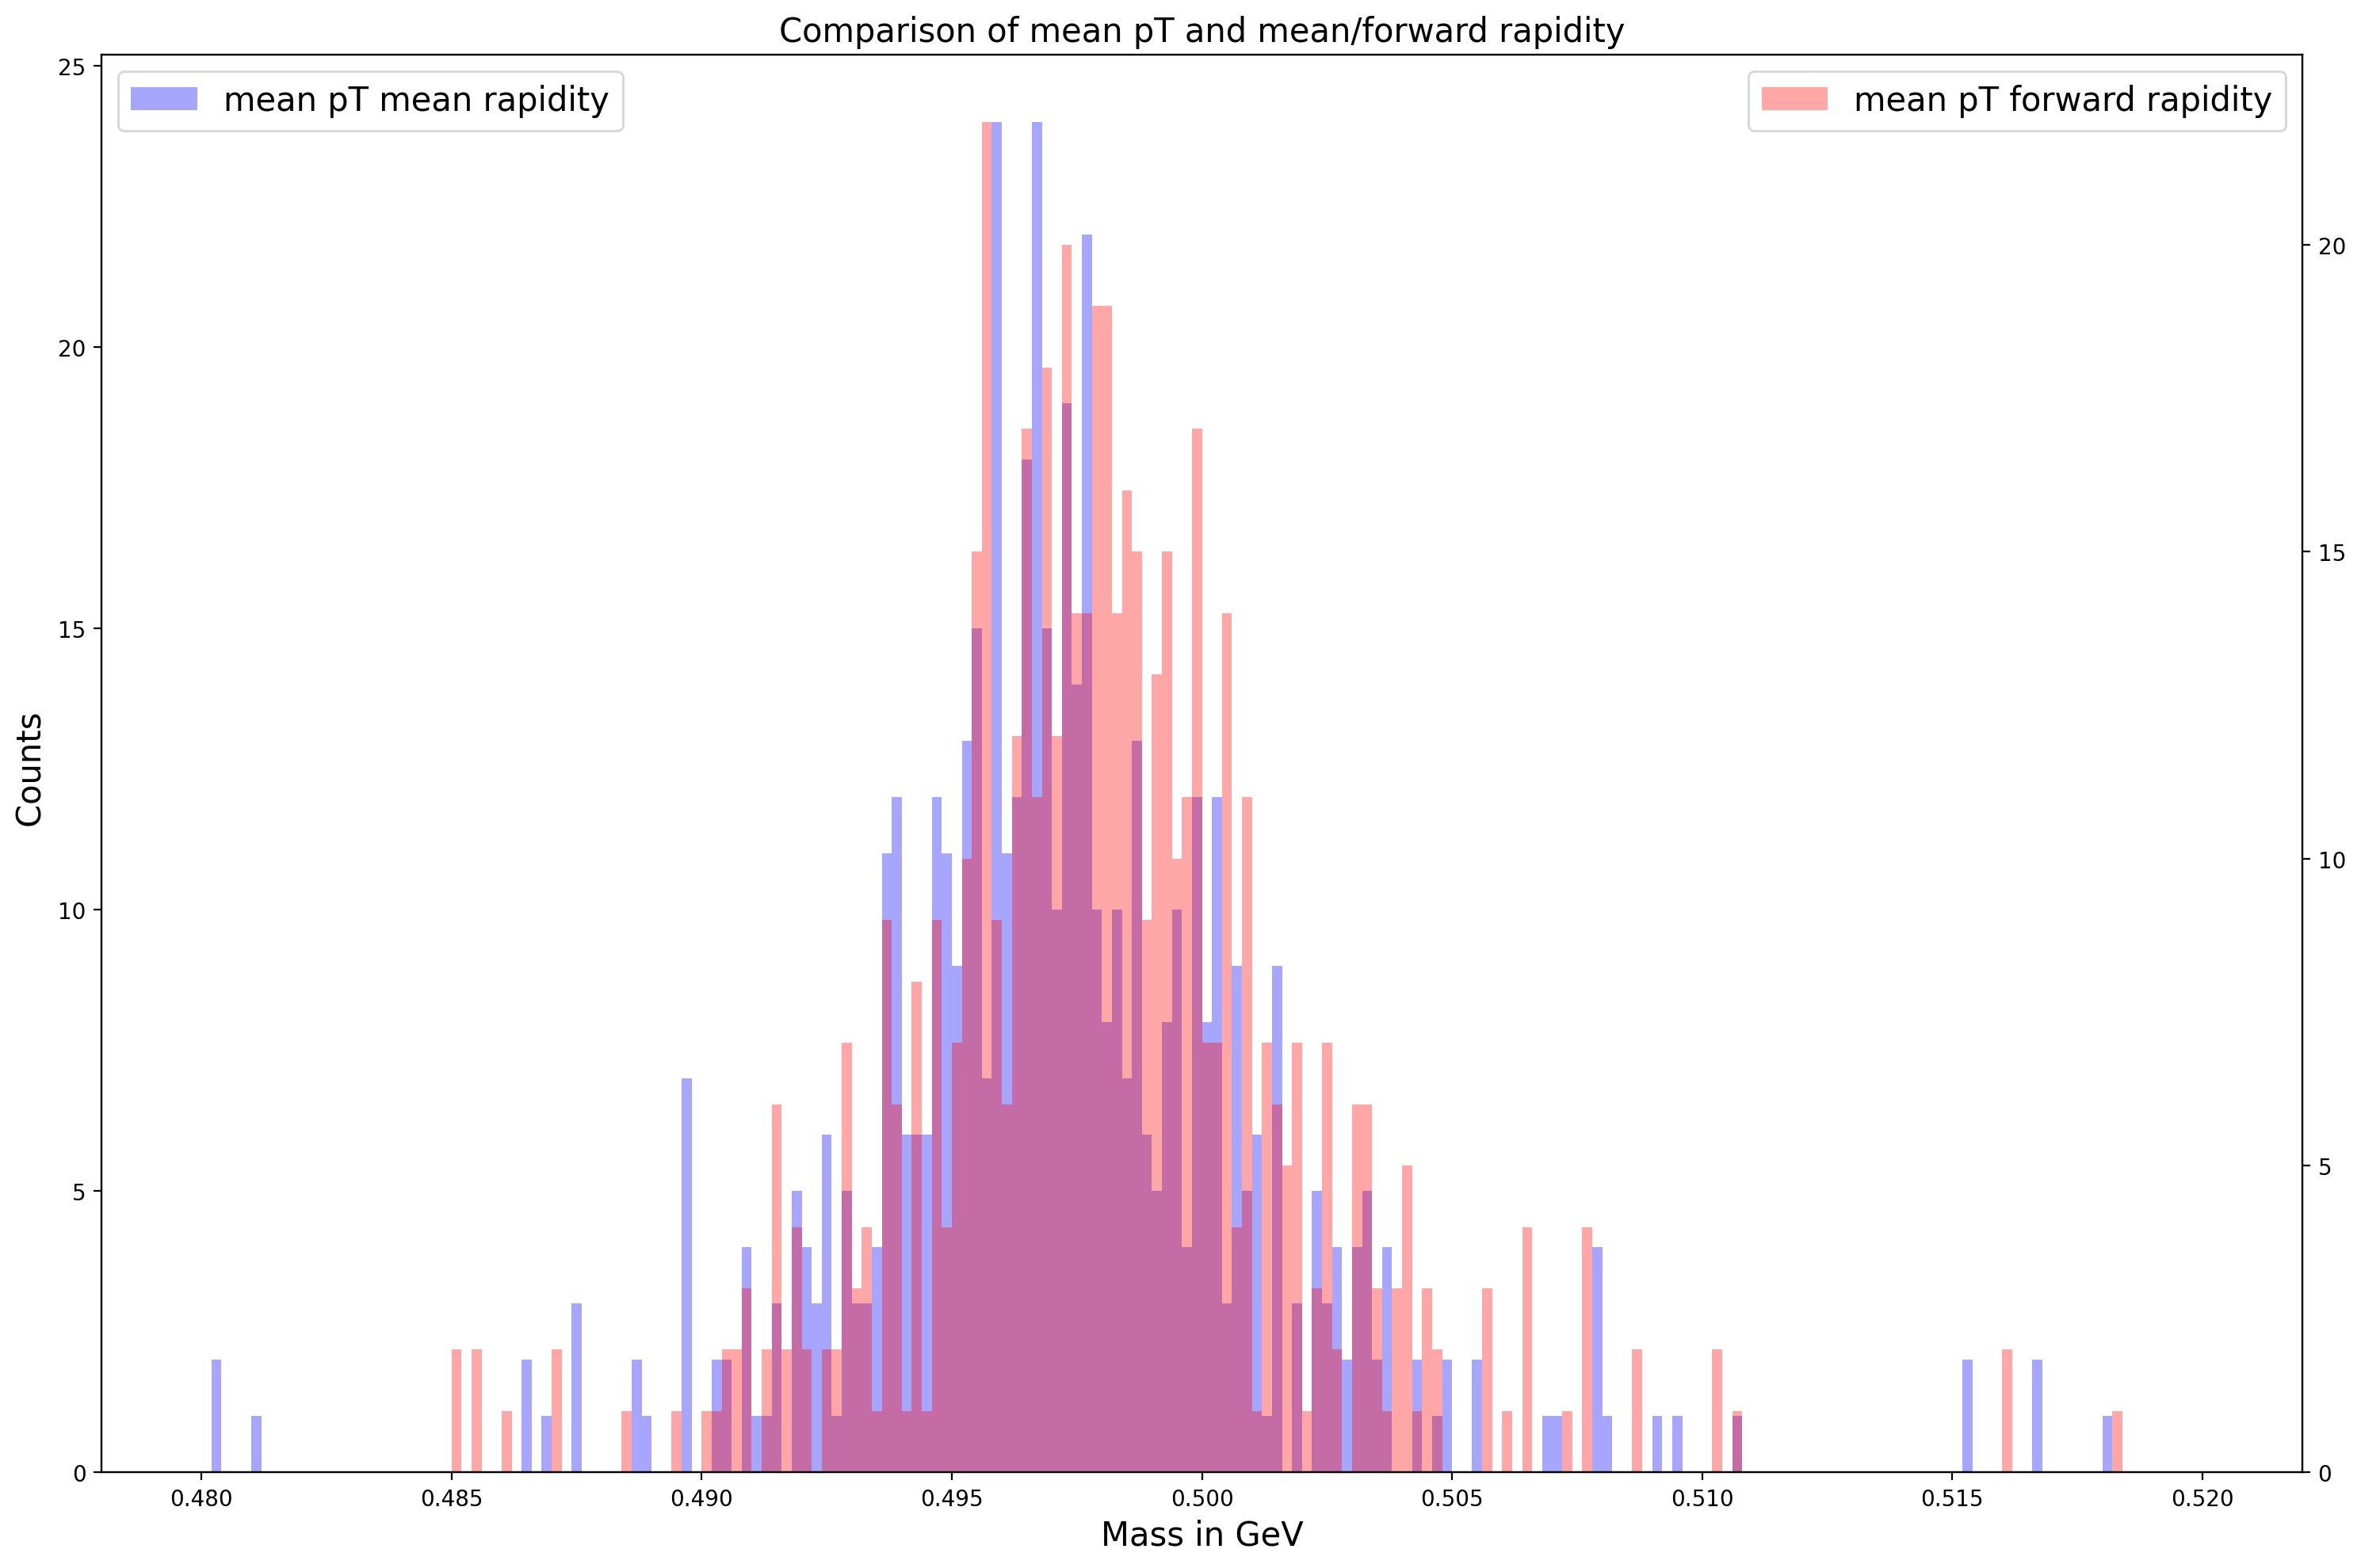

In [47]:
# The following function will display the inavriant mass histogram of the original 10k event set along with the mass histoigram after we apply a cut
# on the probability prediction of xgb
range1=(.48, .52)
bins1= 200

fig, ax2 = plt.subplots(figsize=(15, 10), dpi = 200)
color = 'tab:blue'
ax2.hist(mean_pt_mid_rapidity['mass'],bins = bins1, range=range1, facecolor='blue',alpha = 0.35, label='mean pT mean rapidity')
ax2.set_ylabel('Counts', fontsize = 15)
ax2.legend( fontsize = 15, loc='upper left')

color = 'tab:red'
ax1 = ax2.twinx()
ax1.hist(mean_pt_forward_rapidity['mass'], bins = bins1, range=range1, facecolor='red',alpha = 0.35, label='mean pT forward rapidity')
ax2.set_xlabel('Mass in GeV', fontsize = 15)
ax2.set_ylabel('Counts ', fontsize = 15)
ax2.tick_params(axis='y')
ax1.legend( fontsize = 15,loc='upper right' )

plt.title('Comparison of mean pT and mean/forward rapidity', fontsize = 15)
fig.tight_layout()
fig.savefig(directory+'img/xgb_12agev/chi2geo/meanptrapidity.pdf')
fig.savefig(directory+'img/xgb_12agev/chi2geo/meanptrapidity.png')

# Comparison with the manually optimized cuts of KFPF
In the already existing Kalman Filter Particle Finder (KFPF) package for online reconstruction and selection of short-lived particles in CBM, these criteria have been manually optimized. These selection-cuts have been selected to maximize the signal to background ratio (S/B) of the $\Lambda$ for a certain energy on a collisions generator. The selection criteria mainly depends on the collision energy, decay channel and detector configuration.

In [41]:
#manually selected cuts
manCut_loverdl = 30
manCut_dca = 0.4
manCut_chi2topo = 20
manCut_chi2geo = 12

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted label',fontsize = 15)

Confusion matrix, without normalization
[[22966     0]
 [46255     0]]


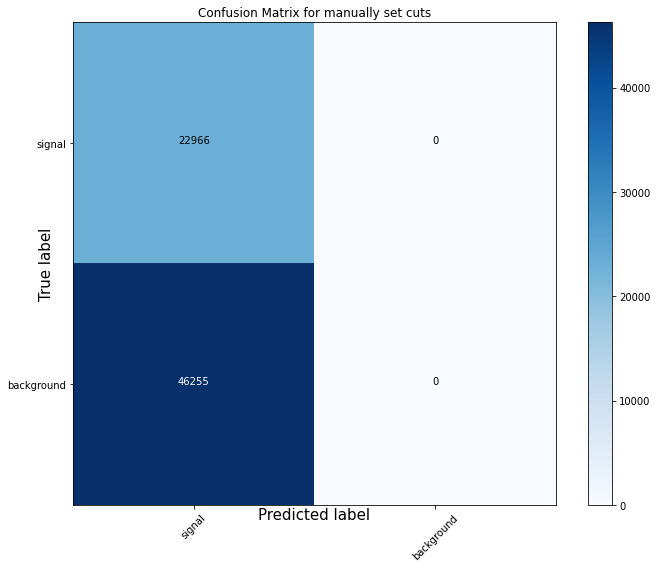

In [43]:
new_check_set= df_clean.copy()
new_check_set['new_signal']=0

# mask1 = (new_check_set['loverdl'] > manCut_loverdl) & (new_check_set['distance'] < manCut_dca)

# mask2 = (new_check_set['chi2topo'] < manCut_chi2topo) & (new_check_set['chi2geo'] < manCut_chi2geo) 

# new_check_set = new_check_set[(mask1) & (mask2)]

mask1 = (new_check_set['chi2primfirst'] > 18.4) & (new_check_set['chi2primsecond'] > 18.4)

mask2 = (new_check_set['loverdl'] > 5) & (new_check_set['distance'] < 1)

mask3 = (new_check_set['chi2geo'] < 3) & (new_check_set['cosinefirst'] > 0) & (new_check_set['cosinesecond'] > 0)

new_check_set = new_check_set[(mask1) & (mask2) & (mask3)]
#After all these cuts, what is left is considered as signal, so we replace all the values in the 'new_signal'
# column by 1
new_check_set['new_signal'] = 1
# new_anticheck_set['new_signal'] = 0
cnf_matrix1 = confusion_matrix(new_check_set['issignal'], new_check_set['new_signal'], labels=[1,0])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
plot_confusion_matrix(cnf_matrix1, classes=['signal','background'], title='Confusion Matrix for manually set cuts')
fig.savefig(directory+'img/xgb_12agev/chi2geo/confusion_matrix_for_manually_set_cuts.pdf')
fig.savefig(directory+'img/xgb_12agev/chi2geo/confusion_matrix_for_manually_set_cuts.png')

In [44]:
confustion_stats(df_clean, cnf_matrix1)

Efficiency: 231.88%
Efficiency of true signal candidates reconstruction: 76.93%
False tu true reconstructed signal ratio: 2.01


In [45]:
cut3 = test_best
mask1 = df_clean['xgb_preds']>cut3
df3=df_clean[mask1]

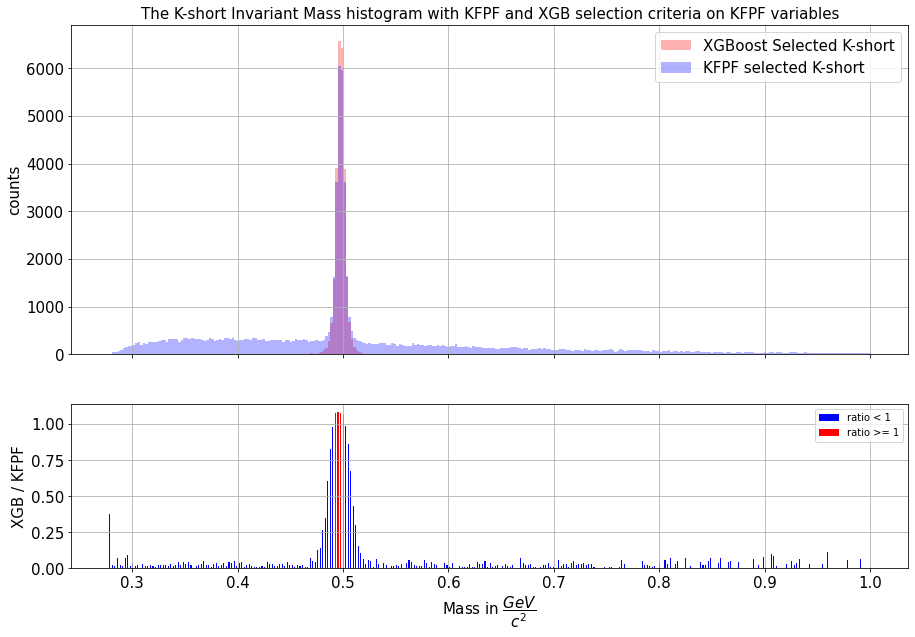

In [46]:
# from matplotlib import gridspec

range1= (lowerMassCut, upperMassCut)


fig, axs = plt.subplots(2, 1,figsize=(15,10), sharex=True,  gridspec_kw={'width_ratios': [10],
                           'height_ratios': [8,4]})

ns, bins, patches=axs[0].hist((df3['mass']),bins = 300, range=range1, facecolor='red',alpha = 0.3)
ns1, bins1, patches1=axs[0].hist((new_check_set['mass']),bins = 300, range=range1,facecolor='blue',alpha = 0.3)
#plt.xlabel("Mass in GeV", fontsize = 15)
axs[0].set_ylabel("counts", fontsize = 15)
#axs[0].grid()
axs[0].legend(('XGBoost Selected K-short','KFPF selected K-short'), fontsize = 15, loc='upper right')

#plt.rcParams["legend.loc"] = 'upper right'
axs[0].set_title("The K-short Invariant Mass histogram with KFPF and XGB selection criteria on KFPF variables", fontsize = 15)
axs[0].grid()
axs[0].tick_params(axis='both', which='major', labelsize=15)
#fig.savefig("whole_sample_invmass_with_ML.png")


hist1, bin_edges1 = np.histogram(df3['mass'],range=(lowerMassCut, upperMassCut), bins=200)
hist2, bin_edges2 = np.histogram(new_check_set['mass'],range=(lowerMassCut, upperMassCut), bins=200)

#ratio checked with division by 0
ratioBlue = [] #ratio smaller than 1
ratioRed = [] # ratio bigger than 1
for i in range(len(ns1)):
    if (ns1[i] != 0):
        ratio = ns[i] / ns1[i]
        if (ratio < 1):
            ratioBlue.append(ratio)
            ratioRed.append(0)
        else:
            ratioBlue.append(0)
            ratioRed.append(ratio)
    else:
        ratioBlue.append(0)
        ratioRed.append(0)
#col = []
# for val in ratio:
#     if val < 1:
#         col.append('blue')
#     else:
#         col.append('red')        
axs[1].bar(bins[:-1],     
        ratioBlue, 
        width=0.001,
        color = 'blue',
        label='ratio < 1')
axs[1].bar(bins[:-1],     
        ratioRed, 
        width=0.001,
        color = 'red',
        label='ratio >= 1')
axs[1].legend( loc='upper right')
plt.xlabel("Mass in $\dfrac{GeV}{c^2}$", fontsize = 15)
axs[1].set_ylabel("XGB / KFPF", fontsize = 15)
axs[1].grid()
#axs[1].set_ylim([0.,2.5])
axs[1].tick_params(axis='both', which='major', labelsize=15)

plt.show()
fig.tight_layout()
fig.savefig(directory+'img/xgb_12agev/chi2geo/kaon_inv_mass_comparison.png')
fig.savefig(directory+'img/xgb_12agev/chi2geo/kaon_inv_mass_comparison.pdf')

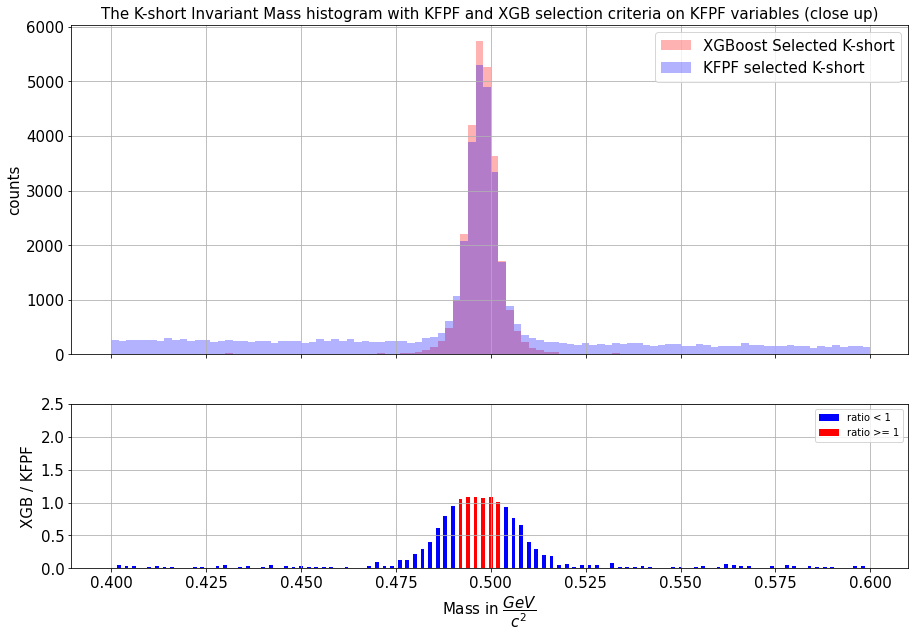

In [47]:
from matplotlib import gridspec

range1= (0.4, 0.6)


fig, axs = plt.subplots(2, 1,figsize=(15,10), sharex=True,  gridspec_kw={'width_ratios': [10],
                           'height_ratios': [8,4]})

ns, bins, patches=axs[0].hist((df3['mass']),bins = 100, range=range1, facecolor='red',alpha = 0.3)
ns1, bins1, patches1=axs[0].hist((new_check_set['mass']),bins = 100, range=range1,facecolor='blue',alpha = 0.3)
#plt.xlabel("Mass in GeV", fontsize = 15)
axs[0].set_ylabel("counts", fontsize = 15)
#axs[0].grid()
axs[0].legend(('XGBoost Selected K-short','KFPF selected K-short'), fontsize = 15, loc='upper right')

#plt.rcParams["legend.loc"] = 'upper right'
axs[0].set_title("The K-short Invariant Mass histogram with KFPF and XGB selection criteria on KFPF variables (close up)", fontsize = 15)
axs[0].grid()
axs[0].tick_params(axis='both', which='major', labelsize=15)
#fig.savefig("whole_sample_invmass_with_ML.png")


hist1, bin_edges1 = np.histogram(df3['mass'],range=(lowerMassCut, upperMassCut), bins=100)
hist2, bin_edges2 = np.histogram(new_check_set['mass'],range=(lowerMassCut, upperMassCut), bins=100)

#ratio checked with division by 0
ratioBlue = [] #ratio smaller than 1
ratioRed = [] # ratio bigger than 1
for i in range(len(ns1)):
    if (ns1[i] != 0):
        ratio = ns[i] / ns1[i]
        if (ratio < 1):
            ratioBlue.append(ratio)
            ratioRed.append(0)
        else:
            ratioBlue.append(0)
            ratioRed.append(ratio)
    else:
        ratioBlue.append(0)
        ratioRed.append(0)
#col = []
# for val in ratio:
#     if val < 1:
#         col.append('blue')
#     else:
#         col.append('red')        
axs[1].bar(bins[:-1],     
        ratioBlue, 
        width=0.001,
        color = 'blue',
        label='ratio < 1')
axs[1].bar(bins[:-1],     
        ratioRed, 
        width=0.001,
        color = 'red',
        label='ratio >= 1')
axs[1].legend( loc='upper right')
plt.xlabel("Mass in $\dfrac{GeV}{c^2}$", fontsize = 15)
axs[1].set_ylabel("XGB / KFPF", fontsize = 15)
axs[1].grid()
axs[1].set_ylim([0.,2.5])
axs[1].tick_params(axis='both', which='major', labelsize=15)

plt.show()
fig.tight_layout()
fig.savefig(directory+'img/xgb_12agev/chi2geo/kaon_inv_mass_comparison_closeup.png')
fig.savefig(directory+'img/xgb_12agev/chi2geo/kaon_inv_mass_comparison_closeup.pdf')

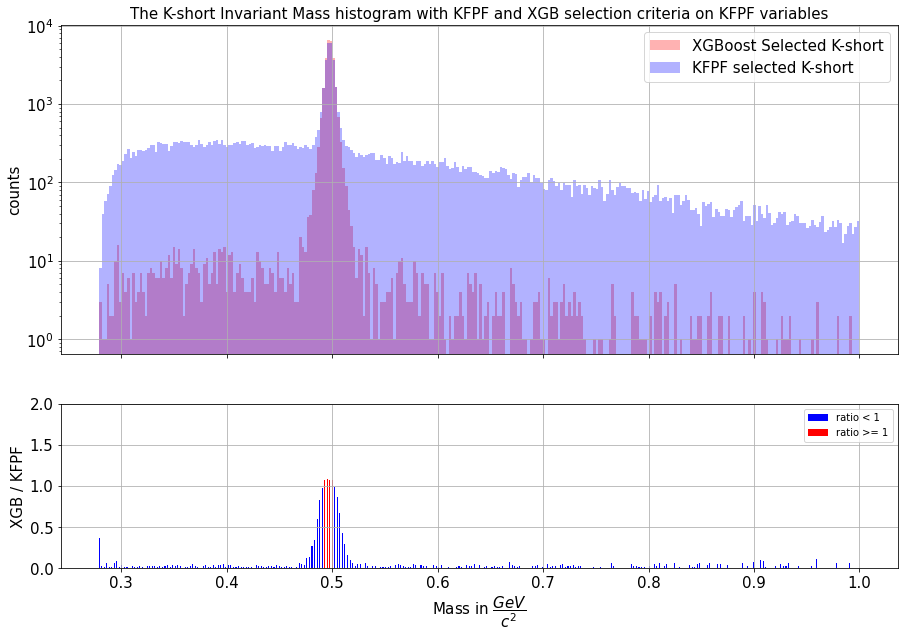

In [48]:
# from matplotlib import gridspec

range1= (lowerMassCut, upperMassCut)


fig, axs = plt.subplots(2, 1,figsize=(15,10), sharex=True,  gridspec_kw={'width_ratios': [10],
                           'height_ratios': [8,4]})

ns, bins, patches=axs[0].hist((df3['mass']),bins = 300, range=range1, facecolor='red',alpha = 0.3)
ns1, bins1, patches1=axs[0].hist((new_check_set['mass']),bins = 300, range=range1,facecolor='blue',alpha = 0.3)
#plt.xlabel("Mass in GeV", fontsize = 15)
axs[0].set_ylabel("counts", fontsize = 15)
axs[0].set_yscale('log')
axs[0].legend(('XGBoost Selected K-short','KFPF selected K-short'), fontsize = 15, loc='upper right')

#plt.rcParams["legend.loc"] = 'upper right'
axs[0].set_title("The K-short Invariant Mass histogram with KFPF and XGB selection criteria on KFPF variables", fontsize = 15)
axs[0].grid()
axs[0].tick_params(axis='both', which='major', labelsize=15)
#fig.savefig("whole_sample_invmass_with_ML.png")


hist1, bin_edges1 = np.histogram(df3['mass'],range=(lowerMassCut, upperMassCut), bins=300)
hist2, bin_edges2 = np.histogram(new_check_set['mass'],range=(lowerMassCut, upperMassCut), bins=300)

#ratio checked with division by 0
ratioBlue = [] #ratio smaller than 1
ratioRed = [] # ratio bigger than 1
for i in range(len(ns1)):
    if (ns1[i] != 0):
        ratio = ns[i] / ns1[i]
        if (ratio < 1):
            ratioBlue.append(ratio)
            ratioRed.append(0)
        else:
            ratioBlue.append(0)
            ratioRed.append(ratio)
    else:
        ratioBlue.append(0)
        ratioRed.append(0)
#col = []
# for val in ratio:
#     if val < 1:
#         col.append('blue')
#     else:
#         col.append('red')        
axs[1].bar(bins[:-1],     
        ratioBlue, 
        width=0.001,
        color = 'blue',
        label='ratio < 1')
axs[1].bar(bins[:-1],     
        ratioRed, 
        width=0.001,
        color = 'red',
        label='ratio >= 1')
axs[1].legend( loc='upper right')
plt.xlabel("Mass in $\dfrac{GeV}{c^2}$", fontsize = 15)
axs[1].set_ylabel("XGB / KFPF", fontsize = 15)
axs[1].set_ylim([0.,2.])
axs[1].grid()
axs[1].tick_params(axis='both', which='major', labelsize=15)

plt.show()
fig.tight_layout()
fig.savefig(directory+'img/xgb_12agev/chi2geo/kaon_inv_mass_comparison.png')
fig.savefig(directory+'img/xgb_12agev/chi2geo/kaon_inv_mass_comparison.pdf')

/var/folders/_8/1pnnpyz111s3q4bf02xypbgc0000gn/T/ipykernel_98248/646598061.py:14: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ns, bins, patches=axs[0].hist((df3_base['mass']),bins = 50,histtype='step', range=range1,Fill=False, color='red', facecolor='red', linewidth=2)
/var/folders/_8/1pnnpyz111s3q4bf02xypbgc0000gn/T/ipykernel_98248/646598061.py:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ns1, bins1, patches1=axs[0].hist((new_check_set['mass']),bins = 50,histtype='step', Fill=False, range=range1,facecolor='blue',linewidth=2)


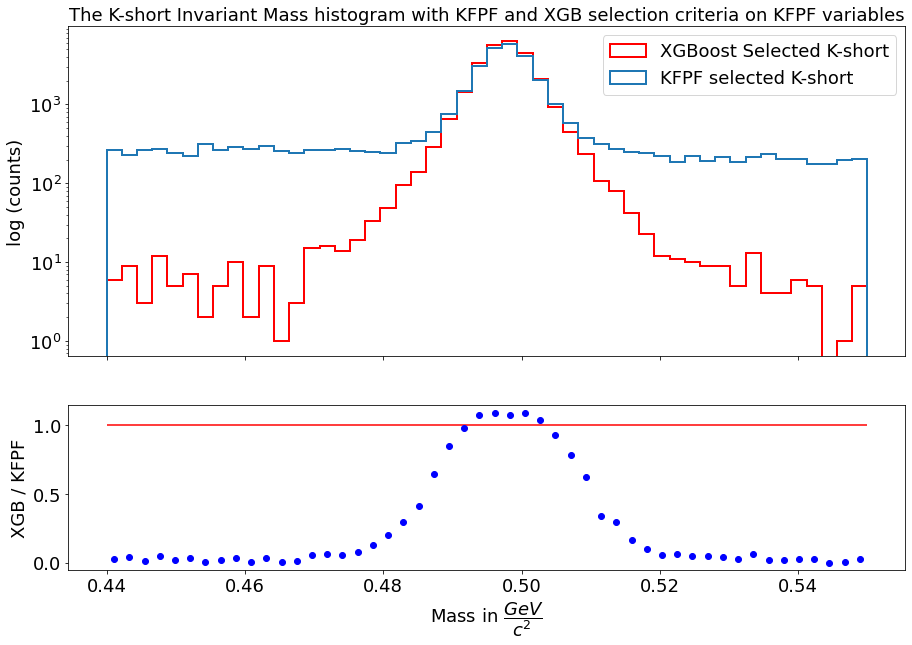

In [49]:
from matplotlib import gridspec

mask1 = df_clean['xgb_preds']>test_best
df3_base=df_clean[mask1]

left = .44
right = .55
range1= (left, right)


fig, axs = plt.subplots(2, 1,figsize=(15,10), sharex=True, gridspec_kw={'width_ratios': [10],
                           'height_ratios': [8,4]})

ns, bins, patches=axs[0].hist((df3_base['mass']),bins = 50,histtype='step', range=range1,Fill=False, color='red', facecolor='red', linewidth=2)
ns1, bins1, patches1=axs[0].hist((new_check_set['mass']),bins = 50,histtype='step', Fill=False, range=range1,facecolor='blue',linewidth=2)
#plt.xlabel("Mass in GeV", fontsize = 15)
axs[0].set_ylabel("log (counts)", fontsize = 18)
#axs[0].grid()
axs[0].legend(('XGBoost Selected K-short','KFPF selected K-short'), fontsize = 18, loc='upper right')

#plt.rcParams["legend.loc"] = 'upper right'
axs[0].set_title("The K-short Invariant Mass histogram with KFPF and XGB selection criteria on KFPF variables", fontsize = 18)
#axs[0].grid()
axs[0].tick_params(axis='both', which='major', labelsize=18)
axs[0].set_yscale('log')
#fig.savefig("whole_sample_invmass_with_ML.png")


hist1, bin_edges1 = np.histogram(df3_base['mass'],range=(left, right), bins=50)
hist2, bin_edges2 = np.histogram(new_check_set['mass'],range=(left, right), bins=50)


#makes sense to have only positive values
diff = (hist1 - hist2)
#axs[1].bar((bins[:-1] + bins[1:]) / 2, # this is what makes it comparable
# ns / ns1, # maybe check for div-by-zero!
# width=0.001)
axs[1].hlines(y=1, xmin=left, xmax=right, colors='r', linestyles='solid', label='')
center = (bins[:-1] + bins[1:]) / 2
plt.errorbar(center, ns / ns1, fmt='o',
                 c='Blue', label='Background in predictions')


    
    
plt.xlabel("Mass in $\dfrac{GeV}{c^2}$", fontsize = 18)
axs[1].set_ylabel("XGB / KFPF", fontsize = 18)
#axs[1].grid()
axs[1].tick_params(axis='both', which='major', labelsize=18)

plt.show()
fig.tight_layout()
fig.savefig(directory+'img/xgb_12agev/chi2geo/circle_kshort_invmass_with_ML.png')

In [50]:
#del bst_test, df3, df3_base, dtest, dtest1, x_train, y_test, y_train, y_whole
gc.collect()
backgroundBefore = df_clean[df_clean['issignal']<1]
signalBefore = df_clean[df_clean['issignal']==1]
backgroundXgb = df_clean[df_clean['xgb_preds1']<1]
signalXgb = df_clean[df_clean['xgb_preds1']==1]
signalKfpf = new_check_set[new_check_set['issignal']==1]
del df_clean, new_check_set
gc.collect()

0

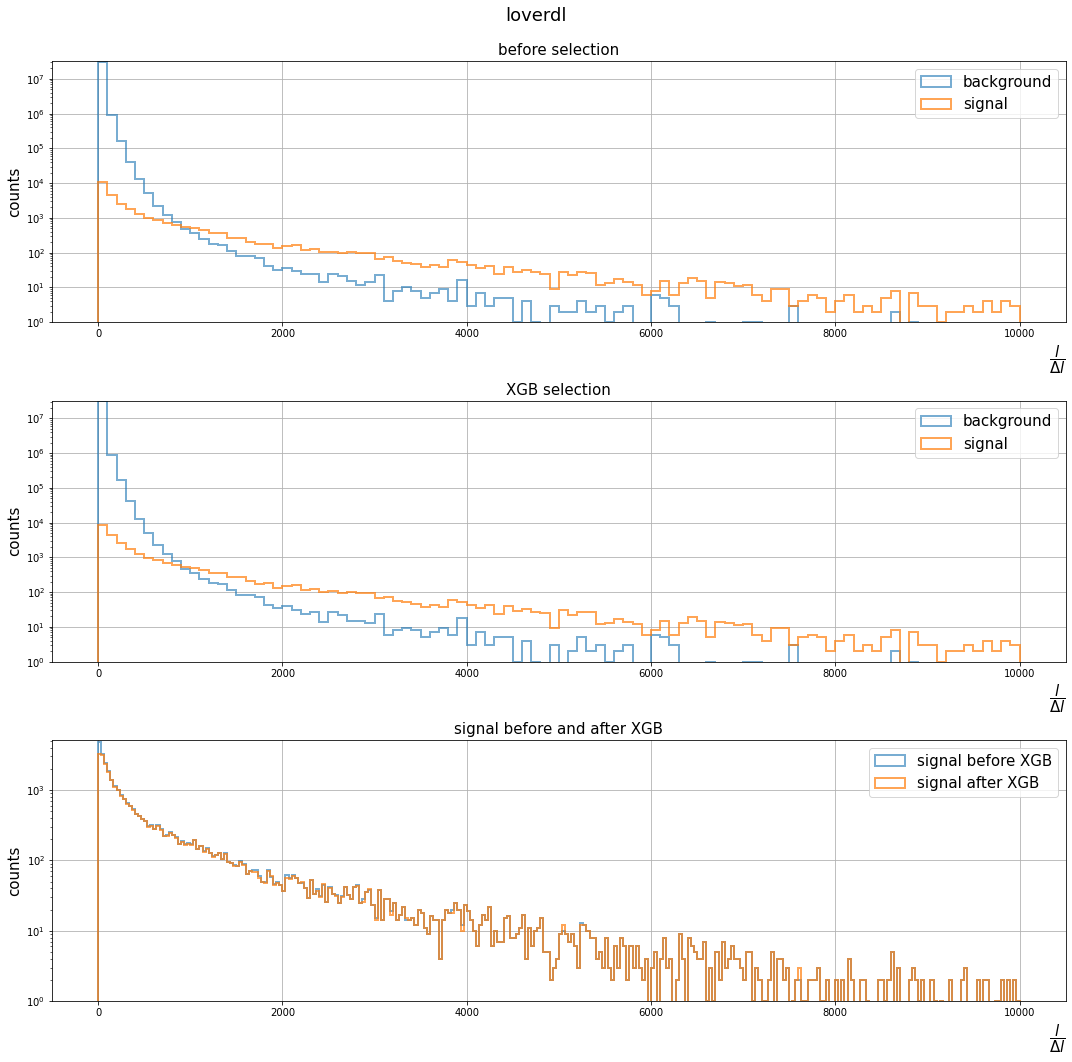

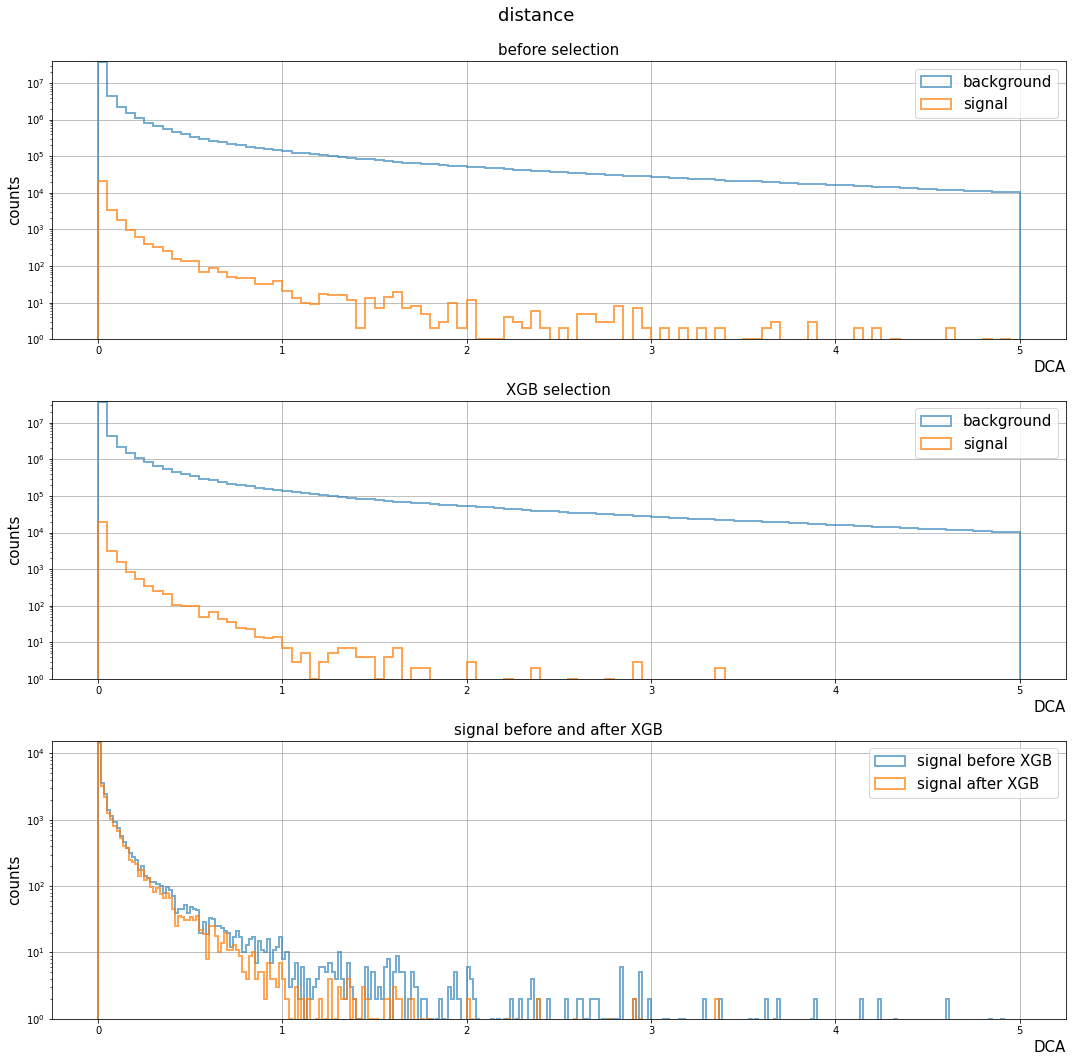

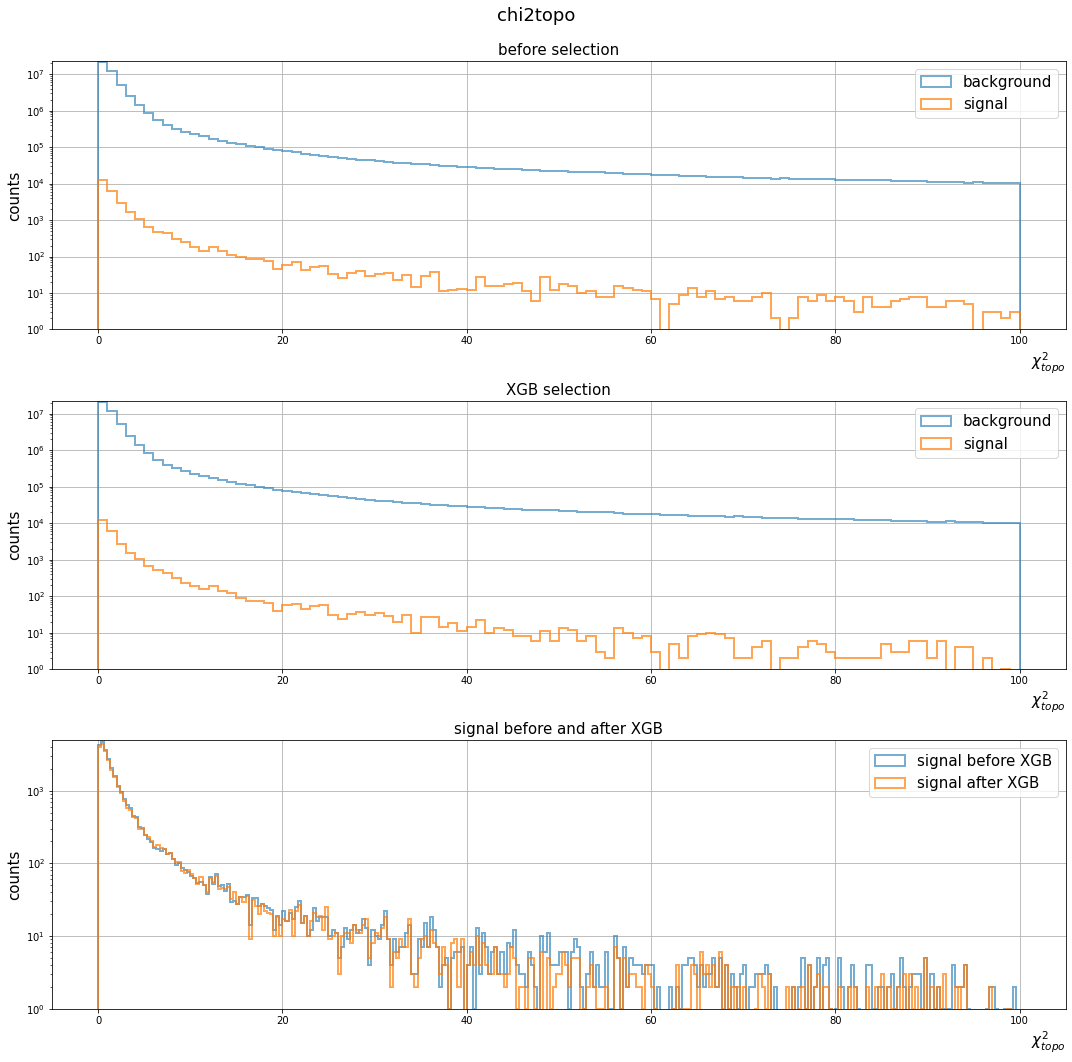

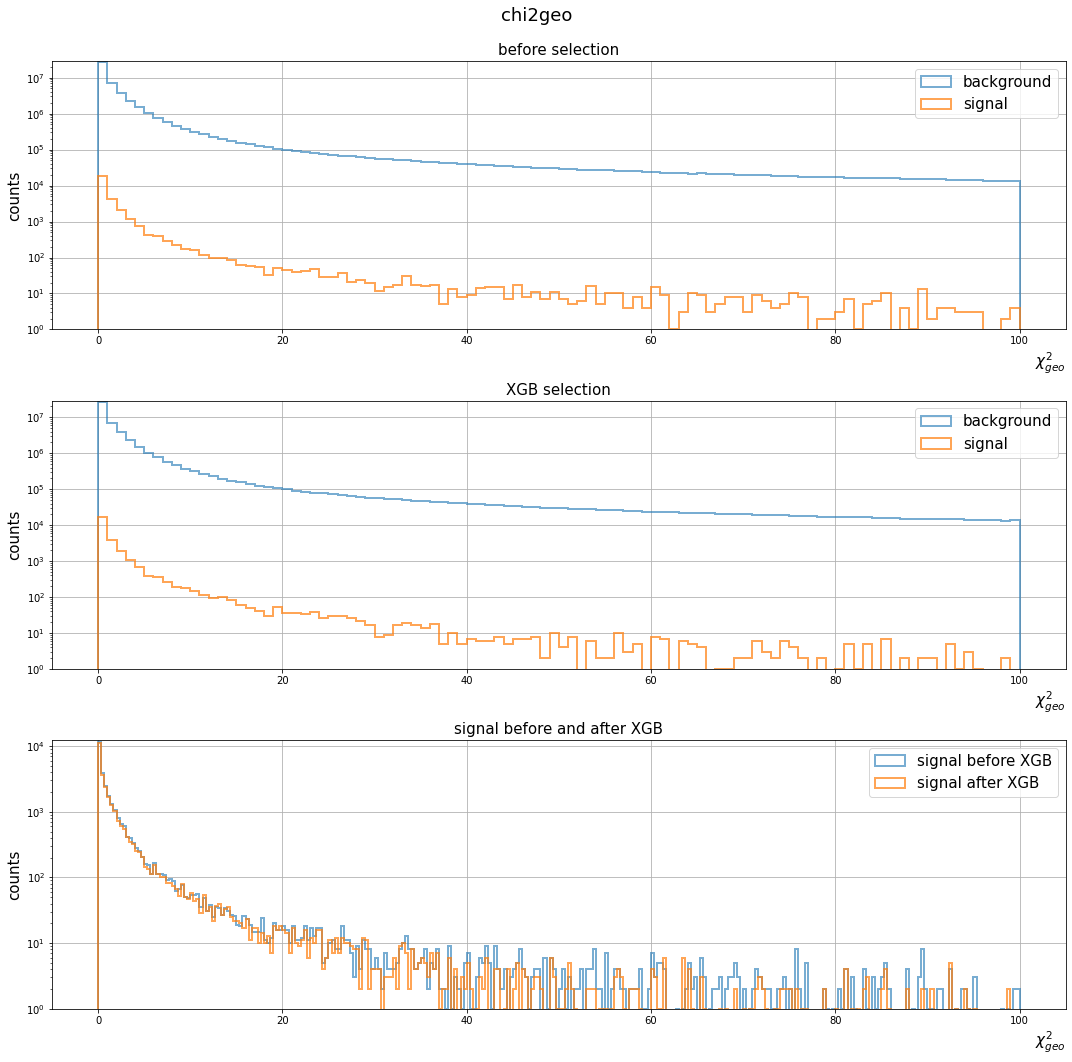

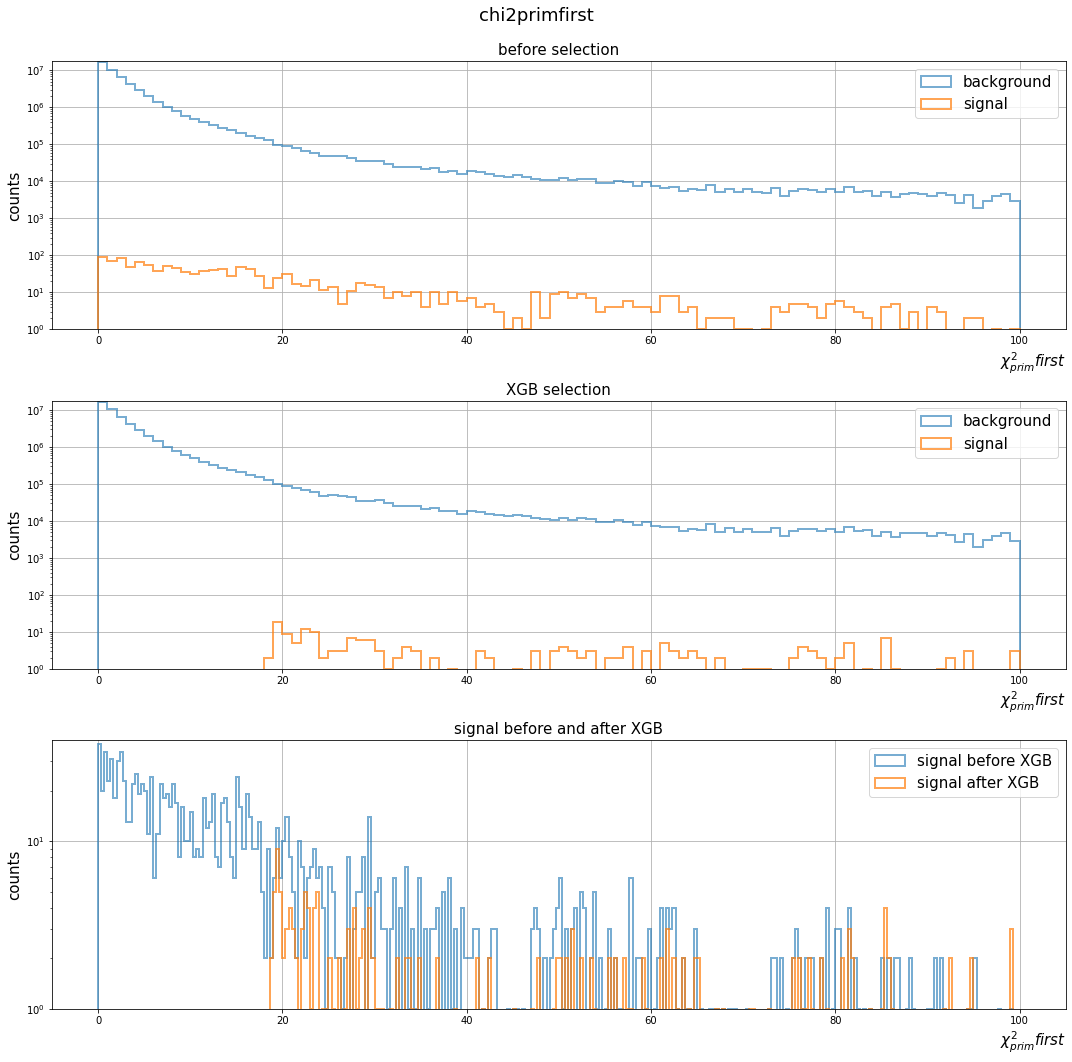

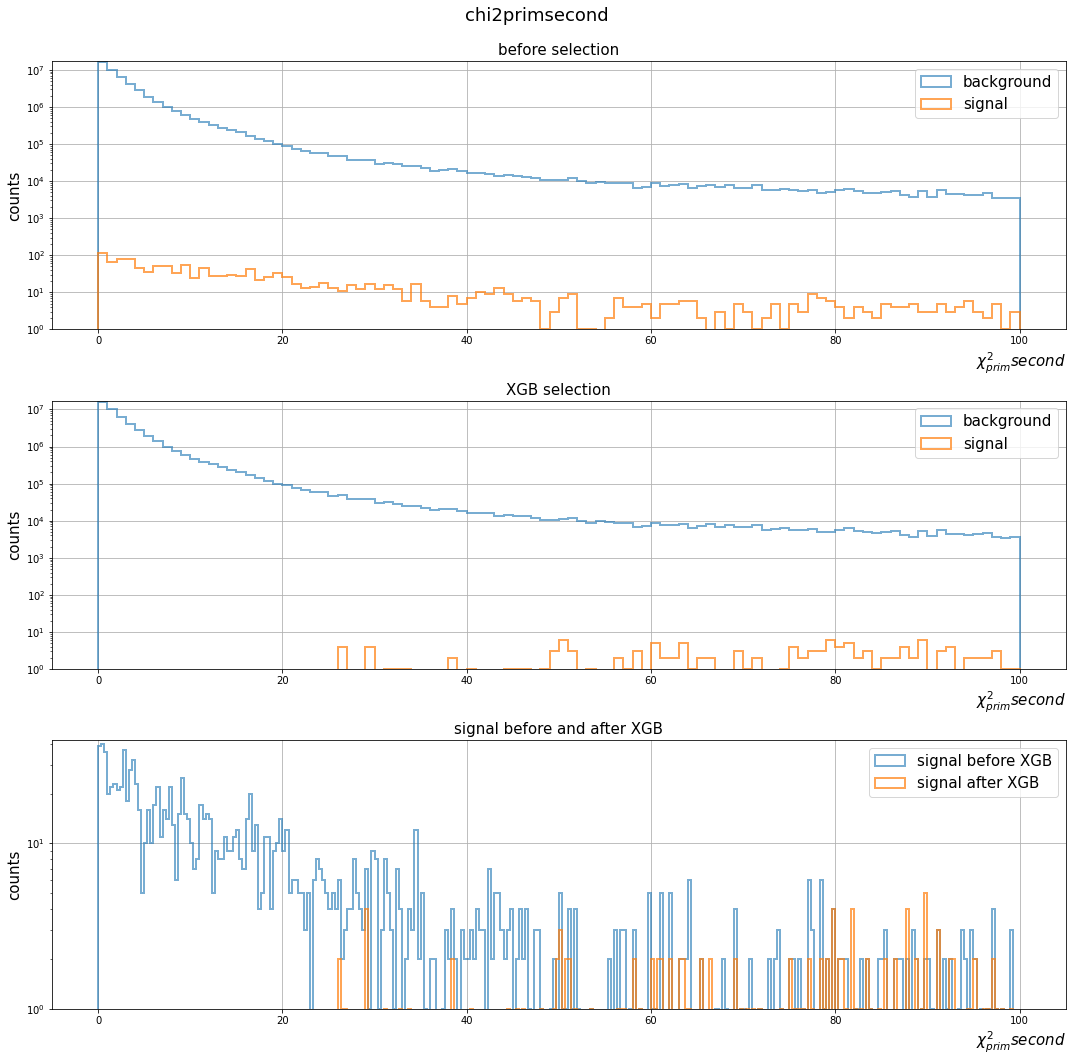

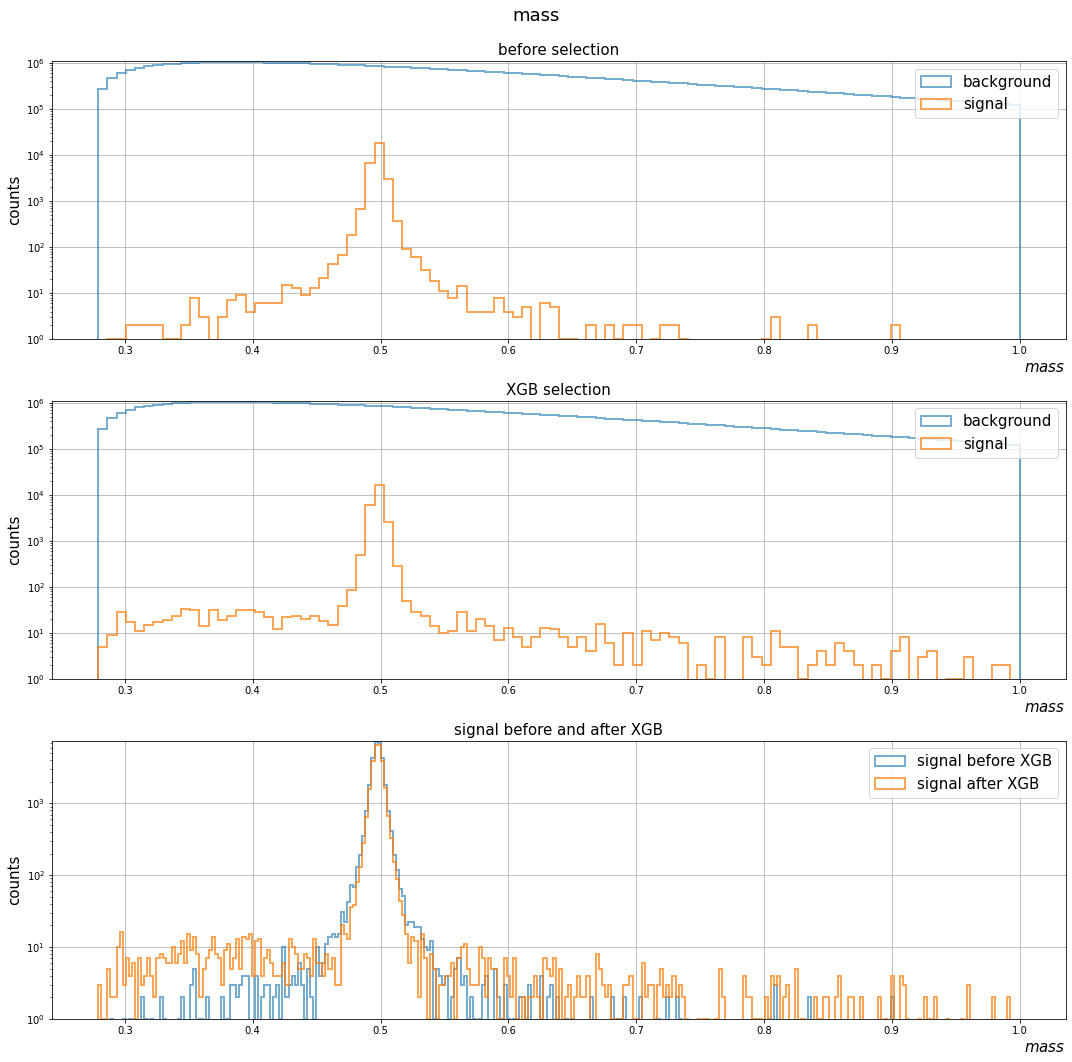

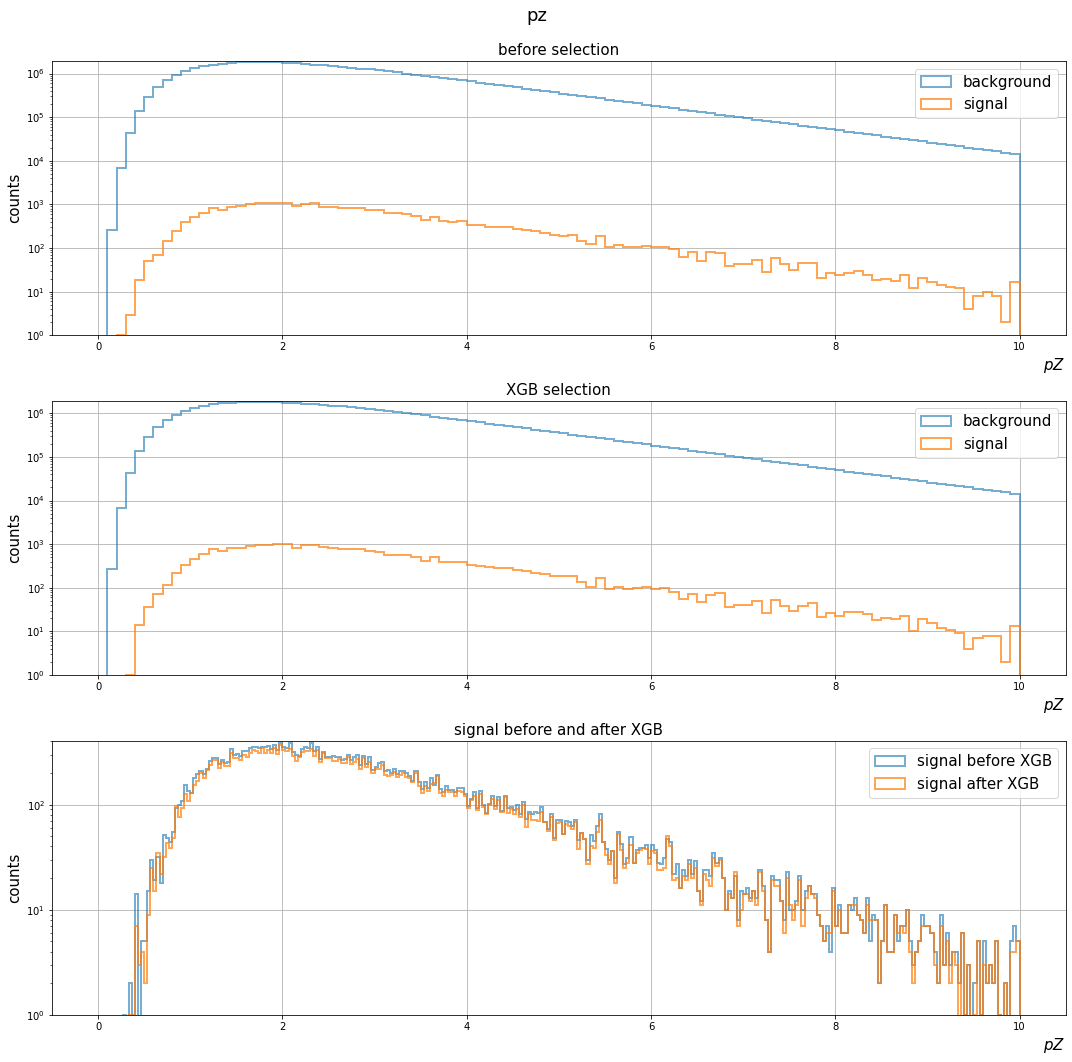

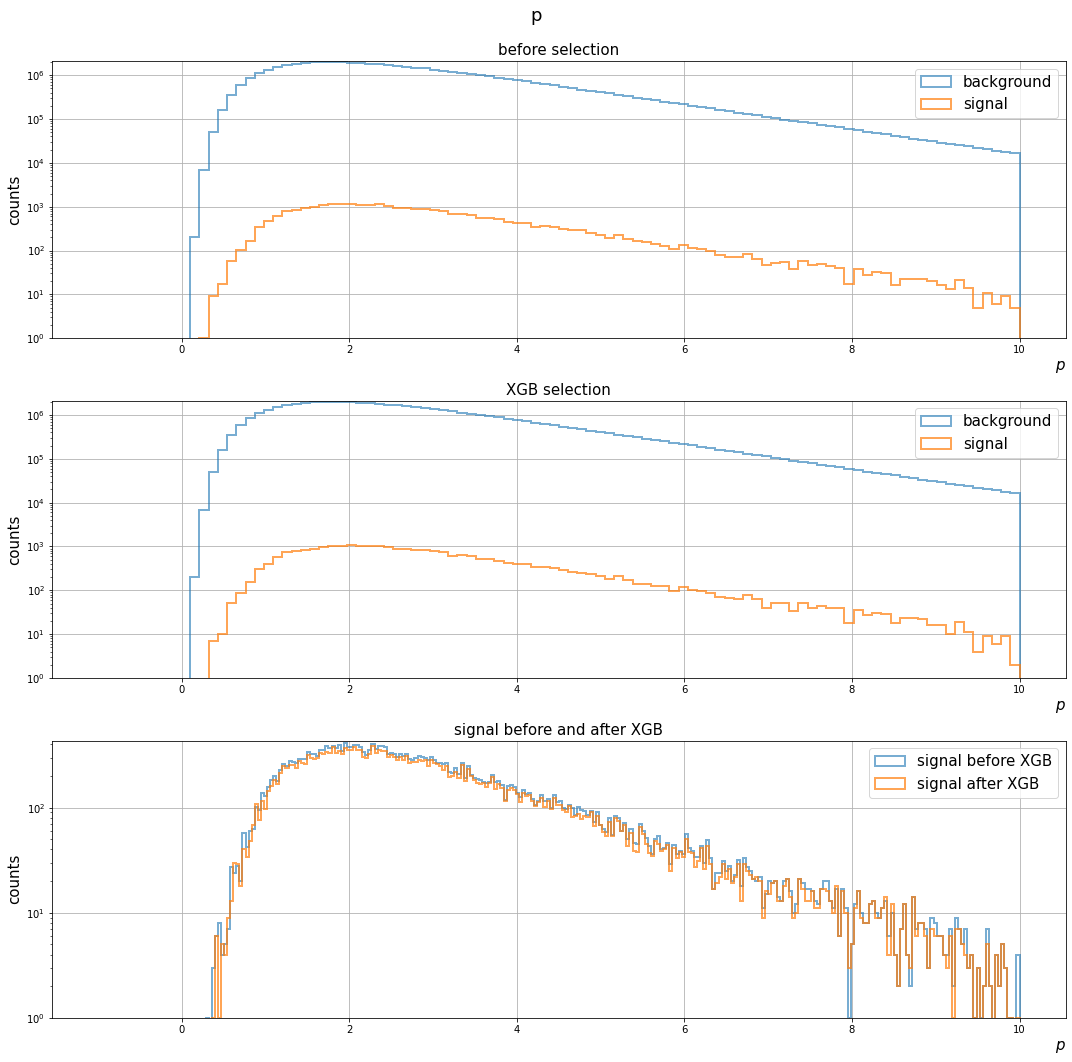

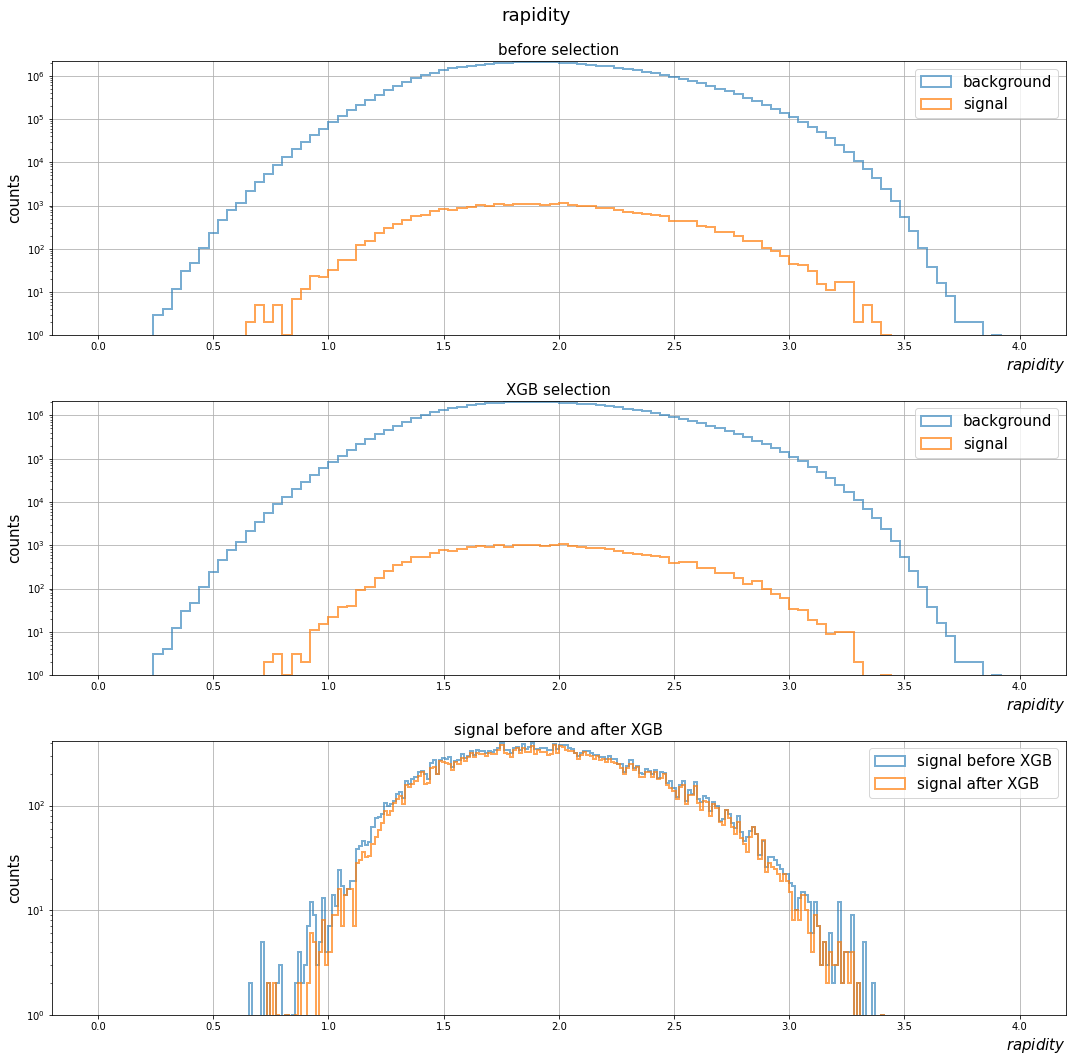

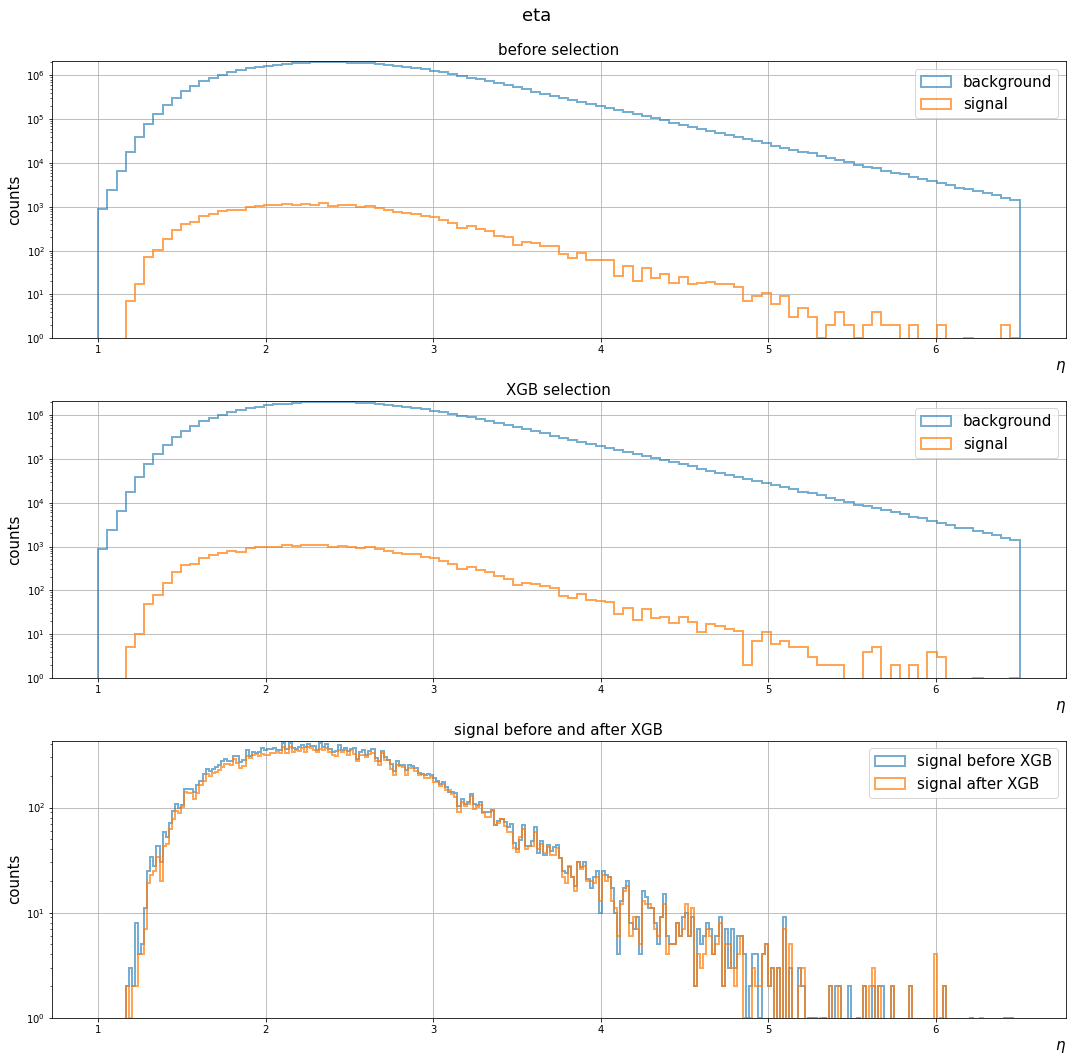

In [51]:
pdf_params = PdfPages(directory+'img/xgb_12agev/chi2geo/params.pdf') 
def plotVariables(par, x_label, ranges):

    fig, axs = plt.subplots(3, 1,figsize=(15,15))#, sharex=True)
    bckgrBefore = backgroundBefore[par]
    signBefore = signalBefore[par]
    bckgrXgb = backgroundXgb[par]
    signXgb = signalXgb[par]

    def subAxis(df1, df2, i, title, ranges=ranges, leg1='background',  leg2='signal', bins=100):
        axs[i].hist(df1,bins = bins, facecolor='blue',alpha = 0.6, histtype='step', fill=False, linewidth=2, range=ranges) 
        axs[i].hist(df2,bins = bins, facecolor='red', alpha = 0.7, histtype='step', fill=False, linewidth=2, range=ranges)
        axs[i].grid()
        axs[i].set_xlabel(x_label, fontsize = 15, loc='right')
        axs[i].set_ylim(bottom=1)
        axs[i].set_ylabel("counts", fontsize = 15)
        axs[i].set_yscale('log')
        axs[i].legend((leg1,leg2), fontsize = 15, loc='upper right')
        axs[i].set_title(title, fontsize = 15)

    subAxis(bckgrBefore,signBefore, 0, 'before selection') 
    subAxis(bckgrXgb,signXgb, 1, 'XGB selection') 
    subAxis(signBefore,signXgb, 2, 'signal before and after XGB', leg1='signal before XGB', leg2='signal after XGB', bins=300) 

    fig.tight_layout()
    fig.savefig(directory+'img/xgb_12agev/chi2geo/' + par + '.png')
    fig.savefig(pdf_params,format='pdf')
    fig.subplots_adjust(top=0.93) #for overall title
    fig.suptitle(par, fontsize = 18)
    plt.show()
#loverdl
par = 'loverdl'
x_label = r'$\dfrac{l}{\Delta l}$'
ranges = (0,10000)
plotVariables(par, x_label, ranges)
#distance
par = 'distance'
x_label = 'DCA'
ranges = (0,5)
plotVariables(par, x_label, ranges)
#chi2topo
par = 'chi2topo'
x_label = r'$\chi^2_{topo}$'
ranges = (0,100)
plotVariables(par, x_label, ranges)
#chi2geo
par = 'chi2geo'
x_label = r'$\chi^2_{geo}$'
plotVariables(par, x_label, ranges)
#chi2primfirst
par = 'chi2primfirst'
x_label = r'$\chi^2_{prim} first$'
plotVariables(par, x_label, ranges)
#chi2primsecond
par = 'chi2primsecond'
x_label = r'$\chi^2_{prim} second$'
plotVariables(par, x_label, ranges)
#mass
par = 'mass'
ranges = (lowerMassCut,upperMassCut)
x_label = r'$mass$'
plotVariables(par, x_label, ranges)
#pZ
par = 'pz'
ranges = (pzLowerCut,10)
x_label = r'$pZ$'
plotVariables(par, x_label, ranges)
#pZ
par = 'p'
ranges = (-1,10)
x_label = r'$p$'
plotVariables(par, x_label, ranges)
#rapidity
par = 'rapidity'
ranges = (0,4)
x_label = r'$rapidity$'
plotVariables(par, x_label, ranges)
#rapidity
par = 'eta'
ranges = (lowerEtaCut,upperEtaCut)
x_label = r'$\eta$'
plotVariables(par, x_label, ranges)
pdf_params.close()

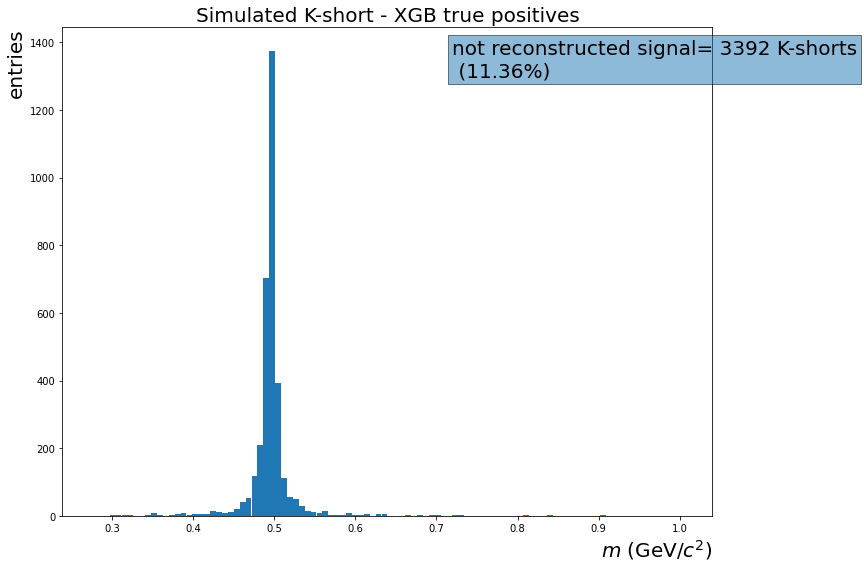

In [53]:
trueSignalXgb = signalXgb[signalXgb['issignal']==1]
fig, ax = plt.subplots(figsize=(12, 8))
name = 'diff_m'
xName = r'$m$ (GeV/$c^2$)'
ranges = (lowerMassCut,upperMassCut)
plt.title('Simulated K-short - XGB true positives', fontsize=20)
plt.xlabel(xName, fontsize=20, loc='right')
plt.ylabel("entries", fontsize=20, loc='top')
before, bins1 = np.histogram(signalBefore['mass'], bins=100, range=ranges)
after, bins2  = np.histogram(trueSignalXgb['mass'], bins=100, range=ranges)
bin_edges = np.linspace(lowerMassCut, upperMassCut, 100)
plt.bar(bin_edges, (before-after), width=(upperMassCut-lowerMassCut)/100 )#fill=False)
plt.annotate('not reconstructed signal= ' + str(sum(before-after)) +' K-shorts\n ('+ str(round(sum(before-after)/sum(before)*100, 2)) + '%)', 
        xy=(0.6, 0.9),xycoords='axes fraction',fontsize = 20, bbox = dict(alpha = 0.5))
#plt.hist(sign[~is_good_sign_mom]['p'], bins=100, label='signal')
#plt.legend(loc='upper right')
fig.tight_layout()
fig.savefig(directory+'img/xgb_12agev/chi2geo/' + 'simulated-truepos' + '.png')

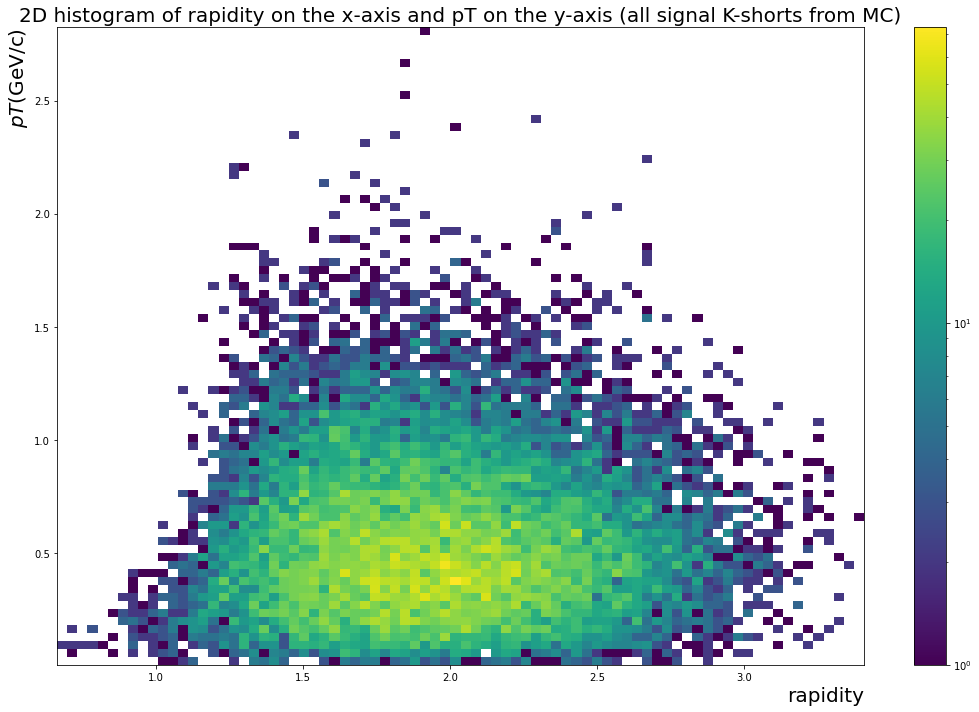

In [59]:
import matplotlib as mpl
var_xaxis = signalBefore['rapidity']
var_yaxis = signalBefore['pT']
#get name with variable from the xnames list
xName = r'rapidity'
yName = r'$pT $(GeV/c)'
ranges = [[.7, 2.5],[0, 2]]
fig, axs = plt.subplots(figsize=(15, 10))
plt.hist2d(var_xaxis,var_yaxis, bins=80, norm=mpl.colors.LogNorm())
hBefore, xedges, yedges = np.histogram2d(var_xaxis, var_yaxis, bins=80, range = ranges) #for efficiency graph
plt.xlabel(xName, fontsize=20, loc='right')
plt.ylabel(yName, fontsize=20, loc='top')
title="2D histogram of "+var_xaxis.name +" on the x-axis and "+var_yaxis.name+" on the y-axis (all signal K-shorts from MC)"
plt.title(title, fontsize=20)
#axs.tick_params(labelsize=18)
fig.tight_layout()
plt.colorbar() #shows legend
fig.savefig(directory+'img/xgb_12agev/chi2geo/' + 'pt-rapidity_before' + '.png')

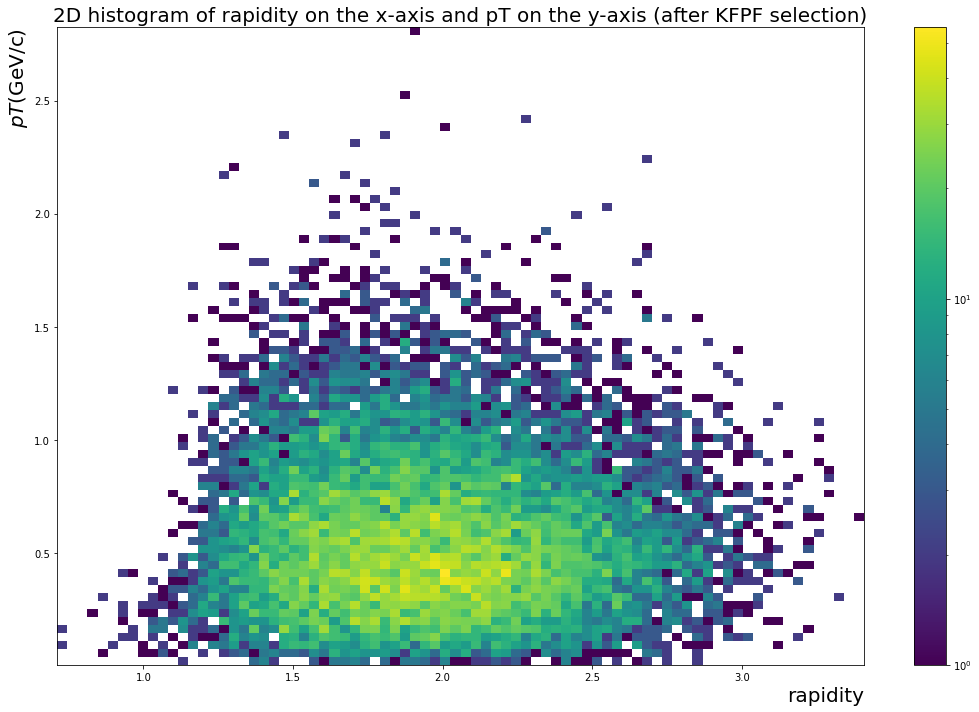

In [60]:
import matplotlib as mpl
var_xaxis = signalKfpf['rapidity']
var_yaxis = signalKfpf['pT']
#get name with variable from the xnames list
fig, axs = plt.subplots(figsize=(15, 10))
plt.hist2d(var_xaxis,var_yaxis, bins=80, norm=mpl.colors.LogNorm())
hAfterKfpf, _, _ = np.histogram2d(var_xaxis, var_yaxis, bins=80, range = ranges) #for efficiency graph
plt.xlabel(xName, fontsize=20, loc='right')
plt.ylabel(yName, fontsize=20, loc='top')
title="2D histogram of "+var_xaxis.name +" on the x-axis and "+var_yaxis.name+" on the y-axis (after KFPF selection)"
plt.title(title, fontsize=20)
#axs.tick_params(labelsize=18)
fig.tight_layout()
plt.colorbar() #shows legend
fig.savefig(directory+'img/xgb_12agev/chi2geo/' + 'pt-rapidity_kfpf' + '.png')

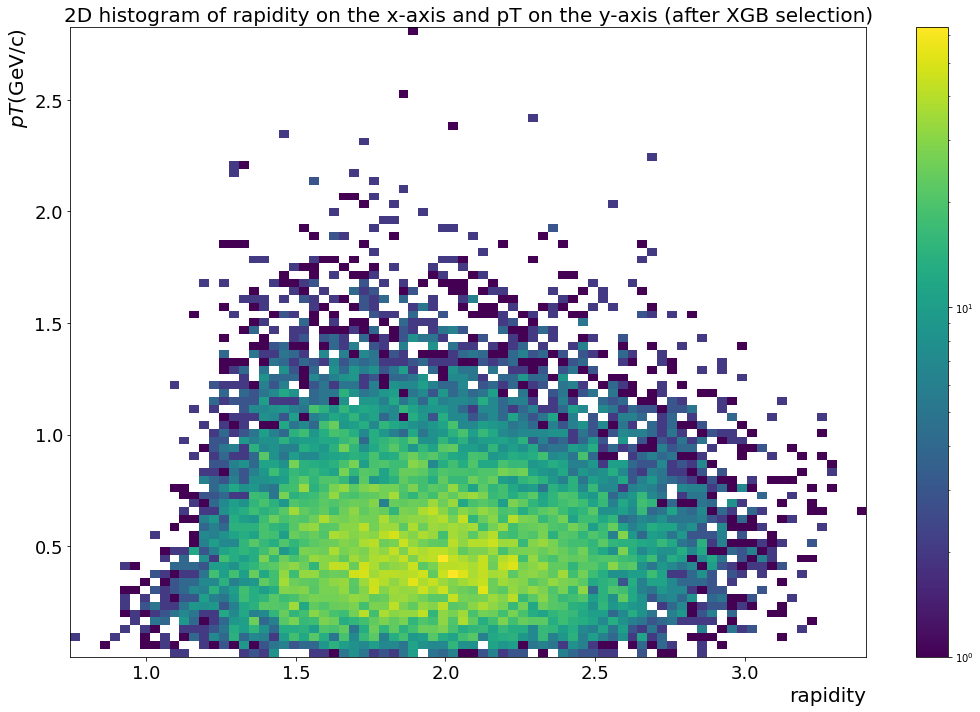

In [56]:
var_xaxis = trueSignalXgb['rapidity']
var_yaxis = trueSignalXgb['pT']
fig, axs = plt.subplots(figsize=(15, 10))
plt.hist2d(var_xaxis,var_yaxis, bins=80, norm=mpl.colors.LogNorm())
hAfter, _, _ = np.histogram2d(var_xaxis, var_yaxis, bins=80, range = ranges)#for efficiency graph
plt.xlabel(xName, fontsize=20, loc='right')
plt.ylabel(yName, fontsize=20, loc='top')
title="2D histogram of "+var_xaxis.name +" on the x-axis and "+var_yaxis.name+" on the y-axis (after XGB selection)"
plt.title(title, fontsize=20)
axs.tick_params(labelsize=18)
fig.tight_layout()
plt.colorbar() #shows legend
fig.savefig(directory+'img/xgb_12agev/chi2geo/' + 'pt-rapidity_after' + '.png')

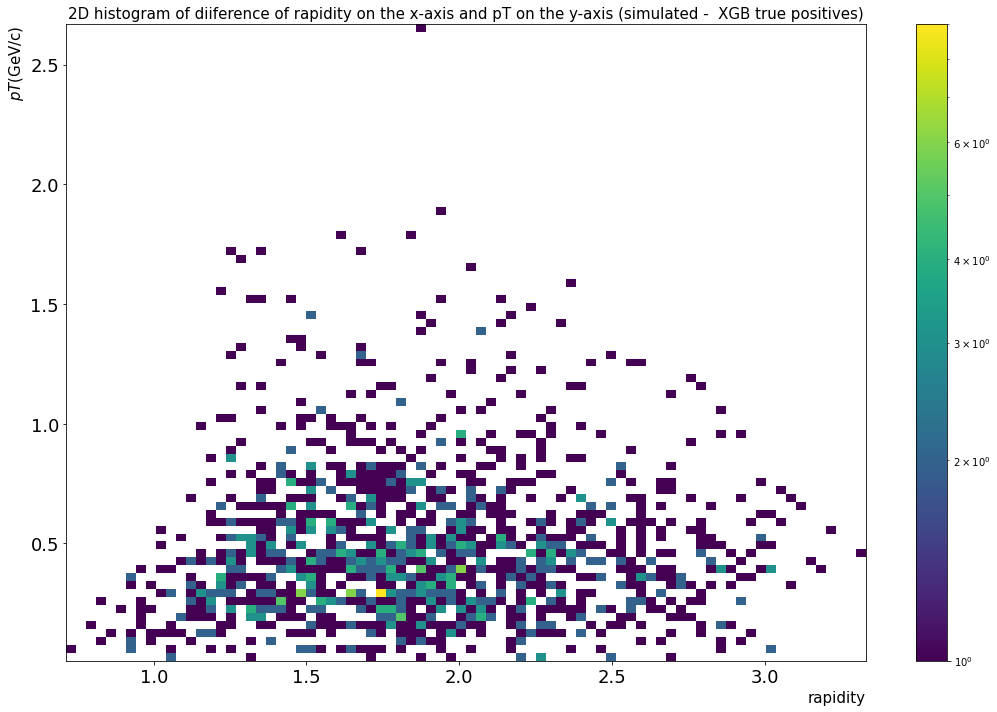

In [57]:
cuts = ['rapidity', 'pT']
def difference_df(df_orig, df_cut, cut):
    return pd.concat([df_orig[cut], df_cut[cut]]).drop_duplicates(keep=False)
difference = difference_df(signalBefore, trueSignalXgb, cuts)

var_xaxis = difference['rapidity']
var_yaxis = difference['pT']
#get name with variable from the xnames list
xName = r'rapidity'
yName = r'$pT$(GeV/c)'
fig, axs = plt.subplots(figsize=(15, 10))
plt.hist2d(var_xaxis,var_yaxis, bins=80, norm=mpl.colors.LogNorm())
plt.xlabel(xName, fontsize=15, loc='right')
plt.ylabel(yName, fontsize=15, loc='top')
title="2D histogram of diiference of "+var_xaxis.name +" on the x-axis and "+var_yaxis.name+" on the y-axis (simulated -  XGB true positives)"
plt.title(title, fontsize=15)
axs.tick_params(labelsize=18)
fig.tight_layout()
plt.colorbar() #shows legend
fig.savefig(directory+'img/xgb_12agev/chi2geo/' + 'pt-rapidity_diff' + '.png')

In [61]:
efficiency = np.divide(hAfter, hBefore, out=np.zeros_like(hAfter), where=hBefore!=0)
print(hBefore)
print(efficiency)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 2. 2. ... 0. 0. 0.]
 [2. 2. 4. ... 0. 0. 2.]
 [3. 2. 1. ... 0. 0. 0.]]
[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   1.   1.   ... 0.   0.   0.  ]
 [1.   1.   0.75 ... 0.   0.   0.  ]
 [0.67 1.   1.   ... 0.   0.   0.  ]]


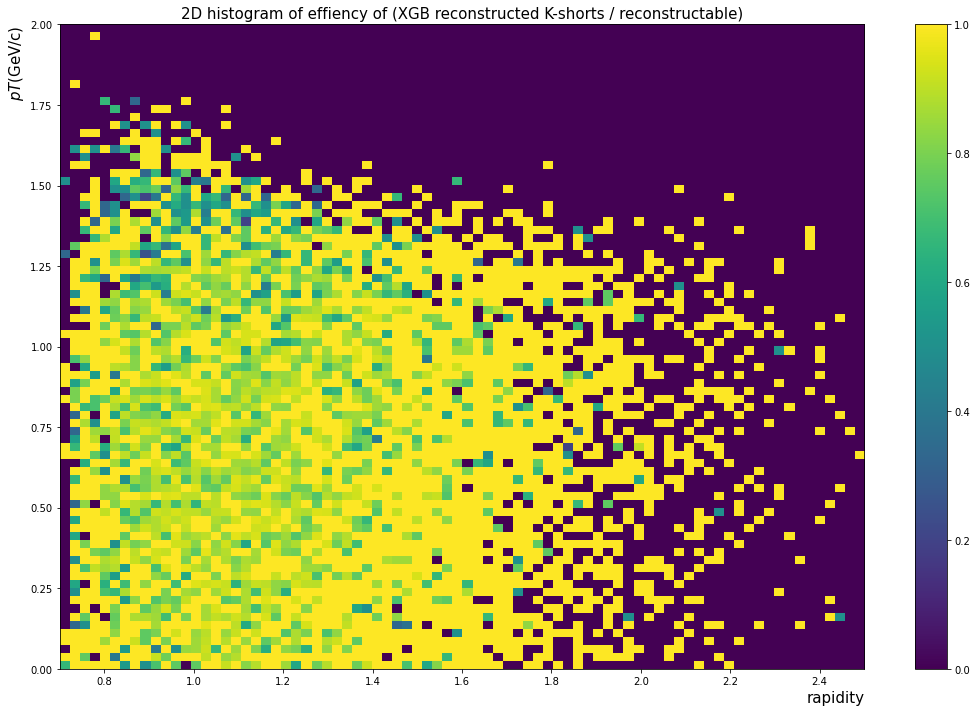

In [65]:
#get name with variable from the xnames list
xName = r'rapidity'
yName = r'$pT$(GeV/c)'
fig, axs = plt.subplots(figsize=(15, 10))
efficiency = np.divide(hAfter, hBefore, out=np.zeros_like(hAfter), where=hBefore!=0) #efficiency
plt.imshow(efficiency, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],interpolation='nearest', aspect='auto')
plt.xlabel(xName, fontsize=15, loc='right')
plt.ylabel(yName, fontsize=15, loc='top')
title="2D histogram of effiency of (XGB reconstructed K-shorts / reconstructable)"
plt.title(title, fontsize=15)
#axs.tick_params(labelsize=18)
fig.tight_layout()
plt.colorbar() #shows legend
fig.savefig(directory+'img/xgb_12agev/chi2geo/' + 'efficency2d' + '.png')

In [ ]:
#get name with variable from the xnames list
xName = r'rapidity'
yName = r'$pT$(GeV/c)'
efficiencyKfpf = np.divide(hAfterKfpf, hBefore, out=np.zeros_like(hAfterKfpf), where=hBefore!=0) #efficiency
fig, axs = plt.subplots(figsize=(15, 10))
plt.imshow(efficiencyKfpf, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],interpolation='nearest', aspect='auto')
plt.xlabel(xName, fontsize=15, loc='right')
plt.ylabel(yName, fontsize=15, loc='top')
title="2D histogram of effiency of (Kfpf reconstructed K-shorts / reconstructable)"
plt.title(title, fontsize=15)
#axs.tick_params(labelsize=18)
fig.tight_layout()
plt.colorbar() #shows legend
fig.savefig(directory+'img/xgb_12agev/chi2geo/' + 'efficency2d_kfpf' + '.png')

In [ ]:
gc.collect()

# Importing the final predictor to root
We will use the treelite library to transport the final predictor of our model to root